# **Skin Lesion CADx Challenge: PART 2 - Multi-class Classification**


Authors: Rachika Elhasna HAMADACHE & Kaouther MOUHEB

In this notebook, we will solve the first part of the CADx project on Skin Lesion Classification using Classical Approaches. This notebook will be divided into two parts: 
1. Binary Classification: Nevus VS Others 
2. Multi-class classification with class imbalance 

Before starting we will import the necessary libraries and create some utils functions to be used later in both tasks. 

## Connect to Google Drive 

* *Mount Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
!pip install scikit-image  --upgrade
!pip install mahotas
!pip install hiclass 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 13.2 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 13.7 MB/s 


In [ ]:
# -----------------------------  GENERAL  -----------------------------
import os
import math
import time
import pickle
import mahotas
import itertools  
import matplotlib
import numpy as np
import pandas as pd
import numpy.ma as ma
from tabulate import tabulate
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# -----------------------------  COMPUTER VISION  -----------------------------
import cv2 as cv
from PIL import Image
from google.colab.patches import cv2_imshow  
from scipy import ndimage
from scipy.spatial.distance import dice
from skimage.color import rgb2lab, lab2rgb
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

# -----------------------------  MACHINE LEARNING  -----------------------------
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, balanced_accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.ensemble import StackingClassifier

# -----------------------------  MODELS  -----------------------------
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier

from hiclass import LocalClassifierPerParentNode, LocalClassifierPerNode, LocalClassifierPerLevel

# -----------------------------  SAMPLING  -----------------------------
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipel
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

## Utils

*The following code subsections will be used for preprocessing and feature extraction*

### Preprocessing helper functions

#### 0. Reading images

In [ ]:
def read_img(img_id, set_):
  """
  img_id : the image's id
  set_   : the image's set ('train' or 'val')
  """  
  cat =  img_id[0:3] 
  path = f"/content/drive/MyDrive/CAD_Dataset/Challenge2/{set_}/{cat}/{img_id}.jpg"
  img = cv.imread(path)
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  return img_rgb

In [ ]:
def read_img_prepro(img_id, set_):
  """
  img_id : the image's id
  set_   : the image's set ('train' or 'val')
  """   
  cat =  img_id[0:3]
  path = f"/content/drive/MyDrive/CAD_Dataset/Challenge2/preprocessed/{set_}/{cat}/{img_id}.jpg"
  img = cv.imread(path)
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  return img_rgb

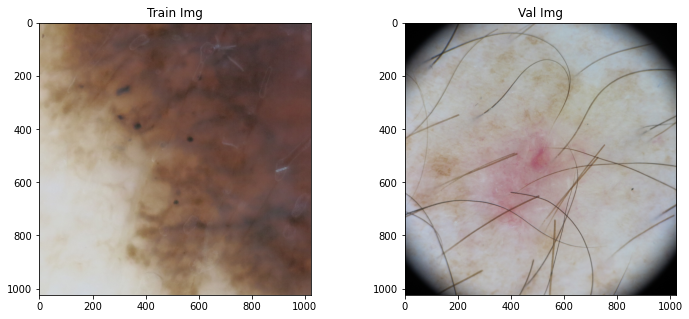

In [ ]:
# --- Function Test --- 
img_id = "mel01628"
img_train = read_img(img_id, "train")

img_id = "bcc02044"
img_val = read_img(img_id, "val")


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()


#### 1. Vignette removal

In [ ]:
def crop_img(img, threshold=100):
    """
    Crop the image to get the region of interest. Remove the vignette frame.
    Analyze the value of the pixels in the diagonal of the image, from 0,0 to h,w and
    take the points where this value crosses the threshold by the first time and for last.
    Args:
    - img (numpy ndarray): Image to crop.
    - threshold (int)    : Value to split the diagonal into image and frame.
    Return:
    - The coordinates of the rectangle and the cropped image.
    """
    # Get the image dimensions
    h, w = img.shape[:2]
    cd = math.gcd(h, w)  # Greatest Common Divider

    # Get the coordinates of the pixels in the diagonal
    y_coords = ([i for i in range(0, h, int(h/cd))], [i for i in range(h - int(h/cd), 0, -int(h/cd))])
    x_coords = ([i for i in range(0, w, int(w/cd))], [i for i in range(0, w, int(w/cd))])

    # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
    # and from h,0 to 0,w
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
    for i in range(2):
        d = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = h, w 
        for y, x in zip(y_coords[i], x_coords[i]):
            d.append(np.mean(img[y, x, :]))

        # Get the location of the first point where the threshold is crossed
        for idx, value in enumerate(d):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Get the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(d)):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i])-idx]
                coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i])-idx]
                break

    # Set the coordinates to crop the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    img_new = img[y1:y2, x1:x2, :]

    if img_new.shape[0] == 0 or img_new.shape[1] == 0:
      img_new = img 
    
    return img_new  #y1, y2, x1, x2, img[y1:y2, x1:x2, :]

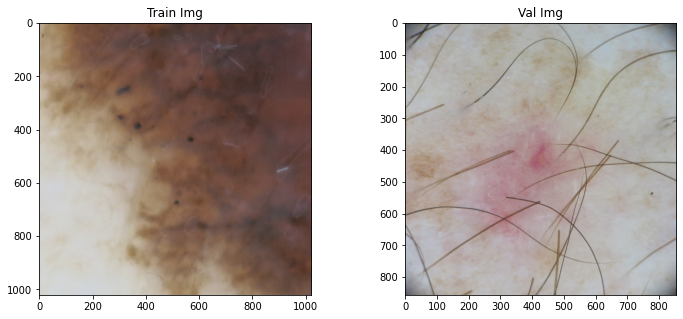

In [ ]:
# --- Function Test ---

img_train_crop = crop_img(img_train, threshold=50)
img_val_crop = crop_img(img_val, threshold=50)


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_crop)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_crop)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

#### 2. Hair Removal

In [ ]:
def inpaint(src, se_size = 15):    
    """
    param : src --> Color image
    return : Inp --> Inpainted image with hair removed"""

    # Convert the original image to grayscale if it has > 1 channel
    if (len(src.shape)==3):
      channel = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    else:
      channel = src

    # Structuring Element for the morphological filtering
    
    se = cv.getStructuringElement(1, (se_size, se_size))  # (17x17) '+' shaped SE
    se2 = np.array(list(reversed(list(zip(*np.eye(se_size)))))) + np.eye(se_size)
    se2[int(se_size/2), int(se_size/2)] = 1  # (17x17) 'X' shaped SE
    
    # Perform the blackHat filtering on the grayscale image to find the 
    # hair (and other objects') countours
    blackhat = cv.morphologyEx(channel, cv.MORPH_BLACKHAT, se)
    blackhat2 = cv.morphologyEx(channel, cv.MORPH_BLACKHAT, se2.astype(np.uint8))
    bHat = blackhat + blackhat2

    # Intensify the countours detected in preparation for the inpainting algorithm
    ret, thresh = cv.threshold(bHat, 10, 255, cv.THRESH_BINARY)

    # Inpaint the original image depending on the mask
    Inp = cv.inpaint(src, thresh, 1, cv.INPAINT_TELEA)

    return Inp

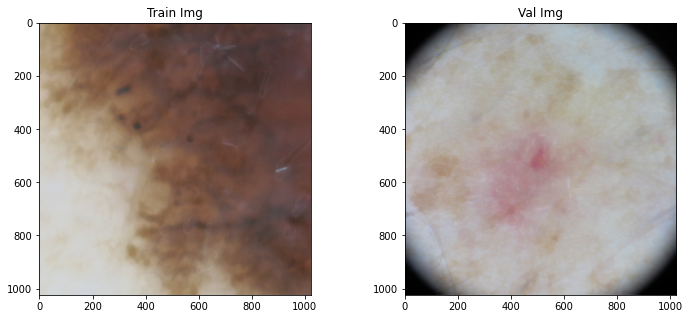

In [ ]:
# --- Function Test ---

img_train_inp = inpaint(img_train)
img_val_inp = inpaint(img_val)


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_inp)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_inp)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

#### 3. Color Constancy 

In [ ]:
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int)      : the degree of norm, 6 is used in reference paper
    gamma (float)    : the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

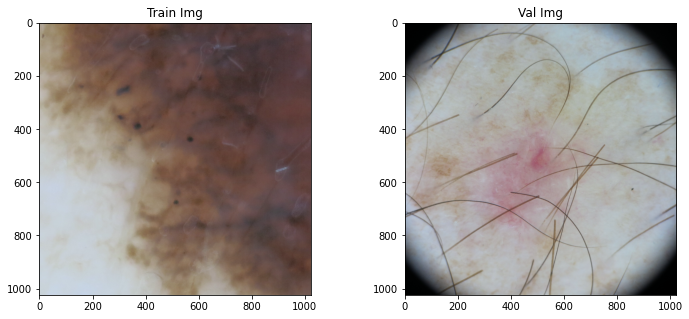

In [ ]:
# --- Function Test ---
img_train_cc = shade_of_gray_cc(img_train)
img_val_cc = shade_of_gray_cc(img_val)


fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_cc)
axes[0].set_title('Train Img')
         
axes[1].imshow(img_val_cc)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

#### 4. Other

Resize images

In [ ]:
def resize_im(img, max_size):   
  """
  img (numpy array): the original image with format of (h, w, c)
  max_size (int)   : the maximum size of the image-s width or height
  """
  scale_percent = round((max_size / max(img.shape[0], img.shape[1])),2)  # Percent to scale images to get ~max_size as the maximum value for width or height while keeping proportions
  width = int(img.shape[1] * scale_percent)
  height = int(img.shape[0] * scale_percent)
  dim = (width, height)
  # Resize image
  image = cv.resize(img, dim, interpolation = cv.INTER_CUBIC)
  return image


In [ ]:
# --- Function Test ---
resized = resize_im(img_train, 500);

print(f"Before: {img_train.shape}\nAfter: {resized.shape}")

Before: (1024, 1024, 3)
After: (501, 501, 3)


Preprocessing function

In [ ]:
def preprocess(img, max_size, crop_params=None, cc_params=None, remove_hair_params=None):
  """
  img (numpy array) : the original image with format of (h, w, c)
  max_size (int)    : the maximum size of the image-s width or height
  crop_params       : parameter 'threshold' from the cropping function 
  cc_params         : parameters 'power' & 'hamma' from the color constancy function 
  remove_hair_params: parameter 'se_size' from the hair removal function 
  """
  if crop_params is not None:
    img = crop_img(img, threshold=crop_params["threshold"])

  img = resize_im(img, max_size)

  if cc_params is not None: 
    img = shade_of_gray_cc(img, power=cc_params["power"], gamma=cc_params["gamma"])

  if remove_hair_params is not None: 
    img = inpaint(img, se_size =  remove_hair_params['se_size'])

  return img

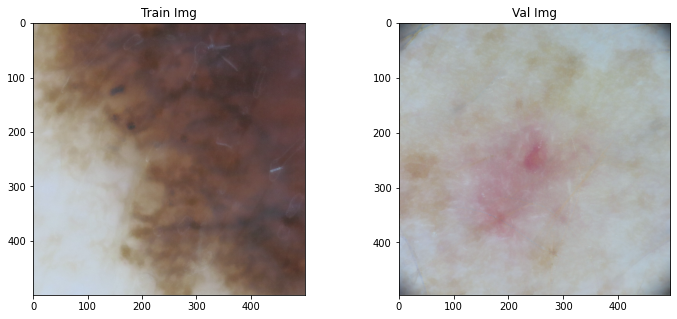

In [ ]:
# --- Function Test ---
img_train_pp = preprocess(img_train, 500, crop_params= {"threshold": 50}, cc_params={"gamma": None, "power":6}, remove_hair_params={'se_size': 9})
img_val_pp = preprocess(img_val, 500, crop_params= {"threshold": 50}, cc_params={"gamma": None, "power":6}, remove_hair_params={'se_size': 9})

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12, 5))

axes[0].imshow(img_train_pp)
axes[0].set_title('Train Img')
        
axes[1].imshow(img_val_pp)
axes[1].set_title('Val Img')

plt.subplots_adjust()
plt.show()

### Feature Extraction helper functions

*In this section, the helper funtions to extract the different features from the images are defined.*

#### Color

In [ ]:
def variegation(Im):
  """param  : Im            --> RGB image
     return : C_r, C_g, C_b --> Color Variegation measures for each RGB Channel """

  # Split Color channels  
  lesion_r = Im[:, :, 0]
  lesion_g = Im[:, :, 1]
  lesion_b = Im[:, :, 2]

  # Compute the normalized Standard Deviation of each channel
  C_r = np.std(lesion_r) / np.max(lesion_r)
  C_g = np.std(lesion_g) / np.max(lesion_g)
  C_b = np.std(lesion_b) / np.max(lesion_b)

  variegation = np.array([C_r, C_g, C_b]).reshape(1, -1)
  return variegation

In [ ]:
# --- Function Test ---
vari_train = variegation(img_train)
vari_val = variegation(img_val)

print(f"Train: {vari_train}\nValid: {vari_val}")
print('Feature shape:', vari_train.shape)

Train: [[0.1997506  0.23975142 0.23150276]]
Valid: [[0.21125056 0.20985752 0.20069838]]
Feature shape: (1, 3)


In [ ]:
def color_moments(Img):
    """ Extract Color Moments of an image.
    --> param Img : ndarray, RGB image
    --> return color_moments : ndarray, contains the 4 Central Color Moments """

    c1, c2, c3 = cv.split(Img)
    color_feature = []  # Initialize the color feature

    # -- The first central moment - average
    c1_mean = np.mean(c1)  # np.sum(h)/float(N)
    c2_mean = np.mean(c2)  # np.sum(s)/float(N)
    c3_mean = np.mean(c3)  # np.sum(v)/float(N)
    color_feature.extend([c1_mean, c2_mean, c3_mean])
    # -- The second central moment - standard deviation
    c1_std = np.std(c1)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    c2_std = np.std(c2)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    c3_std = np.std(c3)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([c1_std, c2_std, c3_std])
    # -- The third central moment - the third root of the skewness
    c1_skewness = np.mean(abs(c1 - c1.mean())**3)
    c2_skewness = np.mean(abs(c2 - c2.mean())**3)
    c3_skewness = np.mean(abs(c3 - c3.mean())**3)
    c1_thirdMoment = c1_skewness**(1./3)
    c2_thirdMoment = c2_skewness**(1./3)
    c3_thirdMoment = c3_skewness**(1./3)
    color_feature.extend([c1_thirdMoment, c2_thirdMoment, c3_thirdMoment])
    # -- The fourth central moment - the variance
    c1_var = c1_std**2  # (np.mean(abs(h - h.mean())**2))
    c2_var = c2_std**2  # (np.mean(abs(s - s.mean())**2))
    c3_var = c3_std**2  # (np.mean(abs(v - v.mean())**2))
    color_feature.extend([c1_var, c2_var, c3_var])

    return np.array(color_feature).reshape(1, -1)

In [ ]:
# --- Function Test --- 
col_mom_train = color_moments(img_train)
col_mom_val = color_moments(img_val)

print(f"Train: {col_mom_train}\nValid: {col_mom_val}")
print('Feature shape:', np.array(col_mom_train).shape)

Train: [[ 135.08493614  111.2534256    98.45874023   44.54438366   53.22481584
    51.85661934   48.55090906   58.87534683   59.54161276 1984.20211546
  2832.88102121 2689.10896963]]
Valid: [[ 161.5031662   156.25331116  154.21871281   43.09511485   42.60107693
    42.5480561    60.56664778   58.61729202   57.87199766 1857.1889243
  1814.85175562 1810.33707815]]
Feature shape: (1, 12)


In [ ]:
def extract_color_histogram(Img, n_bins=64):
    """Extract Color histogram of an image.
    --> param Img : ndarray, RGB image
    --> return feature : ndarray, contains n_bins*n_bins*n_bins of RGB, HSV & L.a.b histogram features of the image
    """
    # --- RGB : ---
    rgb_ft = []
    channels = cv.split(Img)
    colors = ("r", "g", "b")
    for (channel, color) in zip(channels, colors):  
      hist = cv.calcHist([channel], [0], None, [n_bins], [1, 256])     # For each image channel, the normalized histogram is computed
      hist = hist/hist.sum()
      #cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
      rgb_ft.extend(hist)  
    rgb_ft = np.array(rgb_ft).reshape(1, -1)

    # --- HSV : ---
    hsv_ft = []
    hsv = cv.cvtColor(Img, cv.COLOR_RGB2HSV) # Convert the image to HSV color-space
    channels = cv.split(hsv)
    colors = ("h", "s", "v")
    for (channel, color) in zip(channels, colors):
      hist = cv.calcHist([channel], [0], None, [n_bins], [1, 256])  # For each image channel, the normalized histogram is computed
      hist = hist/hist.sum()
      #cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
      hsv_ft.extend(hist)  
    hsv_ft = np.array(hsv_ft).reshape(1, -1)

    # --- LAB : ---
    lab_ft = []
    lab = cv.cvtColor(Img, cv.COLOR_RGB2LAB) # Convert the image to Lab color-space
    channels = cv.split(lab)
    colors = ("l", "a", "b")
    for (channel, color) in zip(channels, colors):
      hist = cv.calcHist([channel], [0], None, [n_bins], [1, 256])  # For each image channel, the normalized histogram is computed
      hist = hist/hist.sum()
      #cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
      lab_ft.extend(hist)  
    lab_ft = np.array(lab_ft).reshape(1, -1)

    return rgb_ft, hsv_ft, lab_ft

In [ ]:
# --- Function Test ---
rgb_tr, hsv_tr, lab_tr = extract_color_histogram(img_train, 100)
rgb_val, hsv_val, lab_val = extract_color_histogram(img_val, 100)
print('Feature shape:', np.array(rgb_tr).shape)

Feature shape: (1, 300)


#### Texture

In [ ]:
def extract_texture_fd(Img, P=16, R=2):
    """Extract Texture Features
    --> param Img : ndarray, RGB image
    --> return texture_features : ndarrays, contains Texture descriptors of the image
    """
    blue_Img = Img[:,:,2]  # Use the blue channel of the Image

    # Local Binary Pattern (LBP) : 
    lbp = local_binary_pattern(blue_Img, P, R, method='uniform')  # P24 R8
    n_bins = int(lbp.max() + 1)
    lbp_fd, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Haralick : 
    haralick_fd = mahotas.features.haralick(blue_Img).mean(axis=0)  # 14 Statistics

    # Gray Level Co-occurance Matrix (GLCM) : 
    distance = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
    glcm_fd = []
    glcm_mat = graycomatrix(blue_Img, distances=distance, angles=angles, symmetric=True, normed=True)
    glcm_fd = np.hstack([graycoprops(glcm_mat, props).ravel() for props in properties])
    lbp_fd = np.array(lbp_fd).reshape(1, -1)
    haralick_fd = np.array(haralick_fd).reshape(1, -1)
    glcm_fd = np.array(glcm_fd).reshape(1, -1)

    return lbp_fd, haralick_fd, glcm_fd

In [ ]:
# --- Function Test ---
lbp_f, haralick_f, glcm_f = extract_texture_fd(img_train, 16, 2)
print('LBP shape:', lbp_f.shape)
print('Haralick shape:', haralick_f.shape)
print('GLCM shape:', glcm_f.shape)

LBP shape: (1, 18)
Haralick shape: (1, 13)
GLCM shape: (1, 20)


#### All

In [ ]:
def extract_save_features(df, partition, crop_params=None, cc_params=None, remove_hair_params=None, lbp_params = None):
    """Extract All Features
    --> df : images dataframe
    --> partition : images' partition ('train', or 'val')
    --> crop_params : parameter 'threshold' from the cropping function 
    --> cc_params : parameters 'power' & 'hamma' from the color constancy function 
    --> remove_hair_params: parameter 'se_size' from the hair removal function 
    --> lbp_params: parameter 'P' & 'R' from the lbp function 
    """

    # Initialize empty arrays to store the features 
    variegation_fd = []
    color_feature_fd = []
    rgb_ft_fd = []
    hsv_ft_fd = []
    lab_ft_fd = []

    # Texture features : 
    lbp_fd = []
    haralick_fd = []
    glcm_fd = []    

    for i, row in df.iterrows():
      print(i)
      img_id = row['image_id']
      img = read_img_prepro(img_id, partition)

      varieg = variegation(img)
      variegation_fd.append(varieg)

      col_mom = color_moments(img)
      color_feature_fd.append(col_mom)

      rgb_tr, hsv_tr, lab_tr = extract_color_histogram(img, 64)
      rgb_ft_fd.append(rgb_tr)
      hsv_ft_fd.append(hsv_tr)
      lab_ft_fd.append(lab_tr)

      lbp_f, haralick_f, glcm_f = extract_texture_fd(img, P=lbp_params['P'], R=lbp_params['R'])
      lbp_fd.append(lbp_f)
      haralick_fd.append(haralick_f)
      glcm_fd.append(glcm_f)

    variegation_fd =  np.squeeze(np.array(variegation_fd), axis=1)
    color_feature_fd =  np.squeeze(np.array(color_feature_fd), axis=1)
    rgb_ft_fd = np.squeeze(np.array(rgb_ft_fd), axis=1)
    hsv_ft_fd =  np.squeeze(np.array(hsv_ft_fd), axis=1)
    lab_ft_fd =  np.squeeze(np.array(lab_ft_fd), axis=1)
    lbp_fd =  np.squeeze(np.array(lbp_fd), axis=1)
    haralick_fd =  np.squeeze(np.array(haralick_fd), axis=1)
    glcm_fd =  np.squeeze(np.array(glcm_fd), axis=1)
    
    return variegation_fd, color_feature_fd, rgb_ft_fd, hsv_ft_fd, lab_ft_fd, lbp_fd, haralick_fd, glcm_fd

### Others

#### Saving the preprocessed images

In [ ]:
def save_imgs(df, partition, img_size, crop_params=None, cc_params=None, remove_hair_params=None):   
    """Extract All Features
    --> df : images dataframe
    --> partition : images' partition ('train', or 'val')
    --> img_size : image size for the preprocessing resize function
    --> crop_params : parameter 'threshold' from the cropping function 
    --> cc_params : parameters 'power' & 'hamma' from the color constancy function 
    --> remove_hair_params: parameter 'se_size' from the hair removal function 
    --> lbp_params: parameter 'P' & 'R' from the lbp function 
    """  
    for i, row in df.iterrows():
      print(i)
      img_id = row['image_id']
      cat = img_id[0:3]
      img = read_img(img_id, partition)
      img = preprocess(img, img_size, crop_params, cc_params, remove_hair_params)
      img_pil = Image.fromarray(img)
      img_pil.save(f'/content/drive/MyDrive/CAD_Dataset/Challenge2/preprocessed/{partition}/{cat}/{img_id}.jpg')

#### Training helper functions

In [ ]:
def sampling_k_elements(group, k=3):
    if len(group) < k:
        return group
    return group.sample(k)

####Validation helper functions

1. Metrics

In [ ]:
def validate_mc(predictions, labels, probabilities = None):
    #TODO: Add AUC, ROC
  scores = {
      "confusion_matrix": confusion_matrix(labels, predictions),
      "accuracy": accuracy_score(labels, predictions),
      "kappa": cohen_kappa_score(labels, predictions),
      "bma": balanced_accuracy_score(labels, predictions)
  }

  return scores

2. Plotting Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=plt.get_cmap('Blues'),
                          normalize=False):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

3. Plotting the ROC curve

In [ ]:
def plot_roc(labels, preds, flag, model_name):
    '''param : labels  --> True classification label
                preds  --> Predicted classification label
                flag   --> Boolean variable to determine if the ROC curves would be plotted (flag==True) or not (flag==False)
                clf    --> String containing the model's name
      return : roc_auc --> Dictionary of AUC values for each class'''  

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3
    class_names = ['Mel', 'Bcc', 'Scc']
    colors = ['#f06e93', '#327ba8', '#f0c96e']
    for i in range(n_classes):
        actuals = (np.array(labels) == i).astype(np.uint8)  # Creating a one-vs-rest array for each class
        fpr[i], tpr[i], _ = roc_curve(actuals, preds[:, i])  # Computing the FPR and TPR
        roc_auc[i] = auc(fpr[i], tpr[i])  # Computing the AUC values for class i

    if(flag == True):  # If flag is True, then display the ROC curves
      for i in range(n_classes):
          plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))  # roc_auc_score

      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic [ROC] for {0} Classifier'.format(model_name))
      plt.legend(loc="lower right")
      plt.show()
    return roc_auc

## Challenge 2: Multi-Class Classification

### Generating CSV Files


Mapping: 

- mel => 0
- bcc => 1
- scc => 2



* *Training set*

In [ ]:
# -------  TRAIN  -------

img_ids = []
labels = []

# melanoma
directory = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train/mel" # Melanoma => label = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img_id = f[-12:-4]
        img_ids.append(img_id)
        labels.append(0)
print('Mel: done')

# bcc
directory = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train/bcc" # BCC => label = 1
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img_id = f[-12:-4]
        img_ids.append(img_id)
        labels.append(1)
print('Bcc: done')

# scc        
directory = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train/scc" # SCC => label = 2
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img_id = f[-12:-4]
        img_ids.append(img_id)
        labels.append(2)
print('Scc: done')

train_df = pd.DataFrame(list(zip(img_ids, labels)),
               columns =['image_id', 'label'])


# train_df.to_csv('/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv')

Mel: done
Bcc: done
Scc: done


* *Validation set*

In [ ]:
# -------  VALIDATION  -------

img_ids = []
labels = []

# melanoma
directory = "/content/drive/MyDrive/CAD_Dataset/Challenge2/val/mel" # Melanoma => label = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img_id = f[-12:-4]
        img_ids.append(img_id)
        labels.append(0)
print('Mel: done')

# bcc
directory = "/content/drive/MyDrive/CAD_Dataset/Challenge2/val/bcc" # BCC => label = 1
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img_id = f[-12:-4]
        img_ids.append(img_id)
        labels.append(1)
print('Bcc: done')

# scc        
directory = "/content/drive/MyDrive/CAD_Dataset/Challenge2/val/scc" # SCC => label = 2
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img_id = f[-12:-4]
        img_ids.append(img_id)
        labels.append(2)
print('Scc: done')

val_df = pd.DataFrame(list(zip(img_ids, labels)),
               columns =['image_id', 'label'])

# val_df.to_csv('/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv')

Mel: done
Bcc: done
Scc: done


### Save preprocessed

*In this section, the images will be preprocess (vignette removal, resizing, hair removal and color normalization), then saved to a shared drive for future use.*

In [ ]:
train_csv = '/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv'
val_csv = '/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv'

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

In [ ]:
print(f'Train=>\t\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation=>\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train=>		 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation=>	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


In [ ]:
# Save preprocessed images :
save_imgs(val_df, 'val', 500, crop_params={'threshold':50}, cc_params={'power':6, 'gamma':None}, remove_hair_params={'se_size': 9})
print('Image preprocessing: done')

Image preprocessing: done


### Extract Features

*In this section, features are extracted (color and texture) from the previously saved preprocessed images and saved in the drive for future use using Pickle.*

In [ ]:
train_csv = '/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv'
val_csv = '/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv'

In [ ]:
val_df = pd.read_csv(val_csv)
train_df_all = pd.read_csv(train_csv)

In [ ]:
print('Train:', len(train_df_all))
print('Val:', len(val_df))

Train: 5082
Val: 1270


* *Plotting samples*

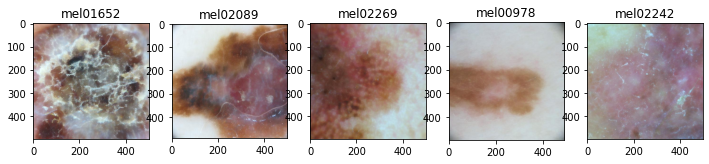

In [ ]:
# Show Train Samples
train_samples = train_df_all.head(5)

fig, axes = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))
ax = 0

for i, row in train_samples.iterrows():
  img_id = row["image_id"]
  img = read_img_prepro(img_id, "train")

  axes[ax].imshow(img)
  axes[ax].set_title(img_id)
  ax +=1 

plt.subplots_adjust()
plt.show()

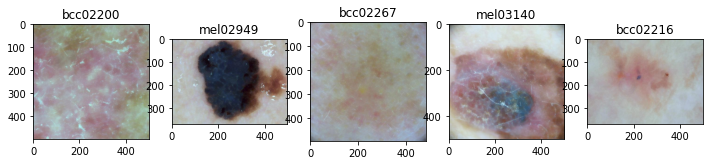

In [ ]:
# Show Validation Samples
val_samples = val_df.sample(5)

fig, axes = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))
ax = 0

for i, row in val_samples.iterrows():
  img_id = row["image_id"]
  img = read_img_prepro(img_id, "val")

  axes[ax].imshow(img)
  axes[ax].set_title(img_id)
  ax +=1 

plt.subplots_adjust()
plt.show()

* *Feature Extraction and saving : Train images*

In [ ]:
variegation_fd, color_feature_fd, rgb_fd, hsv_fd, lab_fd, lbp_fd, haralick_fd, glcm_fd = extract_save_features( train_df_all, 
                                                                                                                'train', 
                                                                                                                500, 
                                                                                                                crop_params={'threshold':50}, 
                                                                                                                cc_params={'power':6, 'gamma':None}, 
                                                                                                                remove_hair_params={'se_size': 9}, 
                                                                                                                lbp_params={'P':16, 'R':2})

In [ ]:
# ----  Save the extracted features in our Save_Folder :  ----
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# --  Save Train Features :
if save_path is not None:      
  # os.makedirs(os.path.join(save_path, 'features_train'), exist_ok=True)
  with open(os.path.join(save_path, 'features/features_train', 'train_variegation_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(variegation_fd, f)
  print("train_variegation_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_color_feature_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(color_feature_fd, f)
  print("train_color_feature_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_rgb_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(rgb_fd, f)
  print("train_rgb_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_hsv_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(hsv_fd, f)
  print("train_hsv_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_lab_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(lab_fd, f)
  print("train_lab_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_lbp_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(lbp_fd, f)
  print("lbp_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_haralick_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(haralick_fd, f)
  print("haralick_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_train', 'train_glcm_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(glcm_fd, f)
  print("glcm_fd were saved..\n")

train_variegation_fd were saved..

train_color_feature_fd were saved..

train_rgb_fd were saved..

train_hsv_fd were saved..

train_lab_ft_fd were saved..

lbp_fd were saved..

haralick_fd were saved..

glcm_fd were saved..



* *Feature Extraction and saving : Validation images*

In [ ]:
val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd = extract_save_features(val_df, 
                                                                                                                                               'val', 
                                                                                                                                               500, 
                                                                                                                                               crop_params={'threshold':50}, 
                                                                                                                                               cc_params={'power':6, 'gamma':None}, 
                                                                                                                                               remove_hair_params={'se_size': 9}, 
                                                                                                                                               lbp_params={'P':16, 'R':2})

In [ ]:
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# --  Save Train Features :
if save_path is not None:      
  # os.makedirs(os.path.join(save_path, 'features_val'), exist_ok=True)
  with open(os.path.join(save_path, 'features/features_val', 'val_variegation_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_variegation_fd, f)
  print("val_variegation_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_color_feature_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_color_feature_fd, f)
  print("val_color_feature_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_rgb_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_rgb_fd, f)
  print("val_rgb_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_hsv_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_hsv_fd, f)
  print("val_hsv_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_lab_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_lab_fd, f)
  print("val_lab_ft_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_lbp_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_lbp_fd, f)
  print("val_lbp_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_haralick_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_haralick_fd, f)
  print("val_haralick_fd were saved..\n")

  with open(os.path.join(save_path, 'features/features_val', 'val_glcm_fd' + '.pkl'), 'wb') as f:
          # pickle.dump(val_glcm_fd, f)
  print("val_glcm_fd were saved..\n")

val_variegation_fd were saved..

val_color_feature_fd were saved..

val_rgb_ft_fd were saved..

val_hsv_ft_fd were saved..

val_lab_ft_fd were saved..

val_lbp_fd were saved..

val_haralick_fd were saved..

val_glcm_fd were saved..



### Train

In this section, five main tasks are performed:
  - Feature sampling 
  - Parameter fine-tuning of each model 
  - Feature selection and dimentionality reduction 
  - Training each model 
  - Validation and Comparison of the results 

For feature selection and dimensionality reduction, multiple techniques will be tried: 
* Ablation study on the different extracted features: first we train the model 
with all features at one, then we remove one of the set of extracted features individually to study the contribution of that set of features in the baseline model. After that we retrain the model with the features which the removal harms the results compared to the baseline. The following sets were tried: 
  *   A : All features
  *   B : All - color moments 
  *   C : All - RGB histograms 
  *   D : All - LAB histograms 
  *   E : All - HSV histograms 
  *   F : All - Texture features
  *   G : All - Variegation 
  *   H : The best features based on the previous results 
* Sci-kit Learn feature selection and dimensionality reduction techniques: 
  * Select k best 
  * PCA 
  * Select from model 


#### Prepare data

In [ ]:
train_csv_all = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv"
val_csv = "/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv"

In [ ]:
train_df = pd.read_csv(train_csv_all)
val_df = pd.read_csv(val_csv)

print(f'Train -->\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation -->\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train -->	 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


##### Train data

In [ ]:
# Open train features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# ---  Read Saved Train Features :  ---------------------------------
with open(os.path.join(save_path, 'features/features_train', 'train_variegation_fd' + '.pkl'), 'rb') as file:
    train_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_color_feature_fd' + '.pkl'), 'rb') as file:
    train_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_rgb_fd' + '.pkl'), 'rb') as file:
    train_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_hsv_fd' + '.pkl'), 'rb') as file:
    train_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_lab_fd' + '.pkl'), 'rb') as file:
    train_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_lbp_fd' + '.pkl'), 'rb') as file:
    train_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_haralick_fd' + '.pkl'), 'rb') as file:
    train_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_glcm_fd' + '.pkl'), 'rb') as file:
    train_glcm_fd = pickle.load(file)    

train_labels = np.array(train_df['label']).squeeze()    

In [ ]:
print('train_variegation_fd shape:', train_variegation_fd.shape)
print('train_color_feature_fd shape:', train_color_feature_fd.shape)
print('train_rgb_fd shape:', train_rgb_fd.shape)
print('train_hsv_fd shape:', train_hsv_fd.shape)
print('train_lab_fd shape:', train_lab_fd.shape)
print('train_lbp_fd shape:', train_lbp_fd.shape)
print('train_haralick_fd shape:', train_haralick_fd.shape)
print('train_glcm_fd shape:', train_glcm_fd.shape)
print('train_labels shape:', train_labels.shape)

train_variegation_fd shape: (5082, 3)
train_color_feature_fd shape: (5082, 12)
train_rgb_fd shape: (5082, 192)
train_hsv_fd shape: (5082, 192)
train_lab_fd shape: (5082, 192)
train_lbp_fd shape: (5082, 18)
train_haralick_fd shape: (5082, 13)
train_glcm_fd shape: (5082, 20)
train_labels shape: (5082,)


##### Validation data

In [ ]:
# Open validation features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'features/features_val', 'val_variegation_fd' + '.pkl'), 'rb') as file:
    val_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_color_feature_fd' + '.pkl'), 'rb') as file:
    val_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_rgb_fd' + '.pkl'), 'rb') as file:
    val_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_hsv_fd' + '.pkl'), 'rb') as file:
    val_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_lab_fd' + '.pkl'), 'rb') as file:
    val_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_lbp_fd' + '.pkl'), 'rb') as file:
    val_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_haralick_fd' + '.pkl'), 'rb') as file:
    val_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_glcm_fd' + '.pkl'), 'rb') as file:
    val_glcm_fd = pickle.load(file)    

val_labels = np.array(val_df['label']).squeeze()    

In [ ]:
print('val_variegation_fd shape:', val_variegation_fd.shape)
print('val_color_feature_fd shape:', val_color_feature_fd.shape)
print('val_rgb_fd shape:', val_rgb_fd.shape)
print('val_hsv_fd shape:', val_hsv_fd.shape)
print('val_lab_fd shape:', val_lab_fd.shape)
print('val_lbp_fd shape:', val_lbp_fd.shape)
print('val_haralick_fd shape:', val_haralick_fd.shape)
print('val_glcm_fd shape:', val_glcm_fd.shape)
print('val_labels shape:', val_labels.shape)

val_variegation_fd shape: (1270, 3)
val_color_feature_fd shape: (1270, 12)
val_rgb_fd shape: (1270, 192)
val_hsv_fd shape: (1270, 192)
val_lab_fd shape: (1270, 192)
val_lbp_fd shape: (1270, 18)
val_haralick_fd shape: (1270, 13)
val_glcm_fd shape: (1270, 20)
val_labels shape: (1270,)


##### Sampling

*In this subsection, sampling is performed by over-sampling the minority class using SMOTE, then under-sampling the two other classes using random undersampling. The final number of samples for each class will be balanced and equal to 1694.*

In [ ]:
print(f'Train -->\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation -->\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train -->	 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


In [ ]:
# Concatenating all Train features :
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, 
                                train_lbp_fd, train_haralick_fd, train_glcm_fd]) 

In [ ]:
# OverUnderSampling using SMOTE approach :
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = pipel(steps=steps)

# Sample the features :
train_features_res, train_labels_res = pipeline.fit_resample(train_features_all, train_labels)
print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save sampled features :
if save_path is not None:   
  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



#### Data visualization


*In this subsection, each of the features will be plotted and compared with their normalized version*

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

print('train_ft:', train_features_all.shape)
print('train_labels:', train_labels_all.shape)

train_ft: (5082, 642)
train_labels: (5082,)


###### Variegation

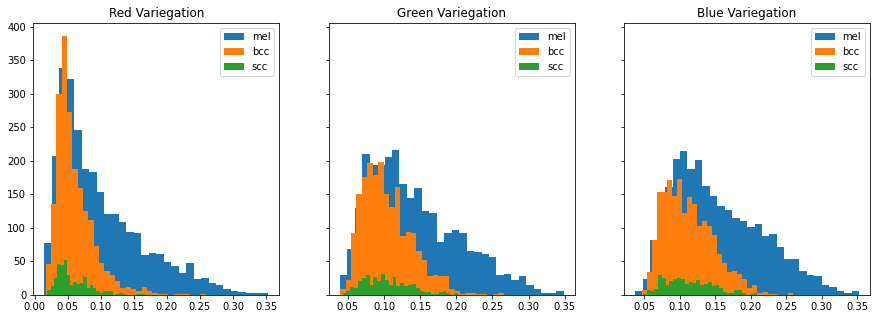

In [ ]:
# -----  Variegation before normalization  -----
variegation_mel_red = train_features_all[train_labels==0, 0]
variegation_mel_green = train_features_all[train_labels==0, 1]
variegation_mel_blue = train_features_all[train_labels==0, 2]

variegation_bcc_red = train_features_all[train_labels==1, 0]
variegation_bcc_green = train_features_all[train_labels==1, 1]
variegation_bcc_blue = train_features_all[train_labels==1, 2]

variegation_scc_red = train_features_all[train_labels==2, 0]
variegation_scc_green = train_features_all[train_labels==2, 1]
variegation_scc_blue = train_features_all[train_labels==2, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Red
bins = 30
axs[0].hist(variegation_mel_red, bins, histtype='stepfilled' , label = "mel")
axs[0].hist(variegation_bcc_red, bins, histtype='stepfilled' , label = "bcc")
axs[0].hist(variegation_scc_red, bins, histtype='stepfilled' , label = "scc")
axs[0].legend()
axs[0].set_title("Red Variegation")

# Green
axs[1].hist(variegation_mel_green, bins, histtype='stepfilled' , label = "mel")
axs[1].hist(variegation_bcc_green, bins, histtype='stepfilled' , label = "bcc")
axs[1].hist(variegation_scc_green, bins, histtype='stepfilled' , label = "scc")
axs[1].legend()
axs[1].set_title("Green Variegation")

# Blue
axs[2].hist(variegation_mel_blue, bins, histtype='stepfilled' , label = "mel")
axs[2].hist(variegation_bcc_blue, bins, histtype='stepfilled' , label = "bcc")
axs[2].hist(variegation_scc_blue, bins, histtype='stepfilled' , label = "scc")
axs[2].legend()
axs[2].set_title("Blue Variegation")

plt.subplots_adjust()
plt.show()

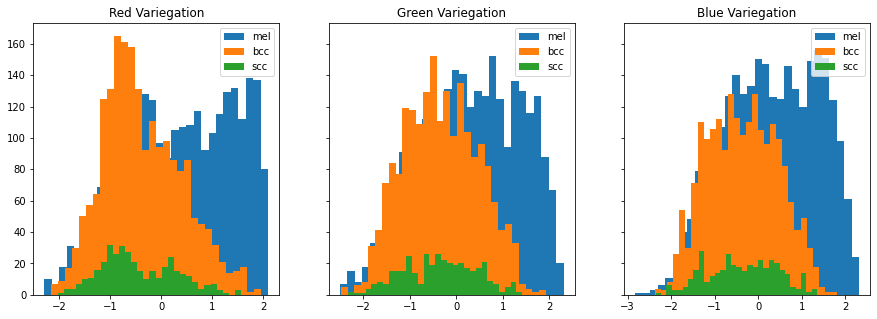

In [ ]:
# -----  Variegation after normalization  -----

transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_variegation_fd_pp = transform.fit_transform(train_features_all[:,0:3])
variegation_mel_red = train_variegation_fd_pp[train_labels==0, 0]
variegation_mel_green = train_variegation_fd_pp[train_labels==0, 1]
variegation_mel_blue = train_variegation_fd_pp[train_labels==0, 2]

variegation_bcc_red = train_variegation_fd_pp[train_labels==1, 0]
variegation_bcc_green = train_variegation_fd_pp[train_labels==1, 1]
variegation_bcc_blue = train_variegation_fd_pp[train_labels==1, 2]

variegation_scc_red = train_variegation_fd_pp[train_labels==2, 0]
variegation_scc_green = train_variegation_fd_pp[train_labels==2, 1]
variegation_scc_blue = train_variegation_fd_pp[train_labels==2, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Red
bins = 30
axs[0].hist(variegation_mel_red, bins, histtype='stepfilled' , label = "mel")
axs[0].hist(variegation_bcc_red, bins, histtype='stepfilled' , label = "bcc")
axs[0].hist(variegation_scc_red, bins, histtype='stepfilled' , label = "scc")
axs[0].legend()
axs[0].set_title("Red Variegation")

# Green
axs[1].hist(variegation_mel_green, bins, histtype='stepfilled' , label = "mel")
axs[1].hist(variegation_bcc_green, bins, histtype='stepfilled' , label = "bcc")
axs[1].hist(variegation_scc_green, bins, histtype='stepfilled' , label = "scc")
axs[1].legend()
axs[1].set_title("Green Variegation")

# Blue
axs[2].hist(variegation_mel_blue, bins, histtype='stepfilled' , label = "mel")
axs[2].hist(variegation_bcc_blue, bins, histtype='stepfilled' , label = "bcc")
axs[2].hist(variegation_scc_blue, bins, histtype='stepfilled' , label = "scc")
axs[2].legend()
axs[2].set_title("Blue Variegation")

plt.subplots_adjust()
plt.show()

###### RGB Histograms

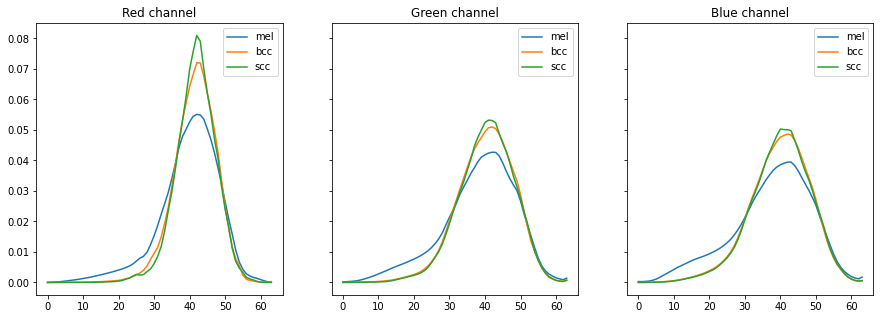

In [ ]:
# -----  RGB Color Histogram before normalization  -----

rgb_mel_red = np.mean(train_features_all[train_labels==0, 15:79], axis = 0)
rgb_mel_green = np.mean(train_features_all[train_labels==0, 79:143], axis = 0)
rgb_mel_blue = np.mean(train_features_all[train_labels==0, 143:207], axis = 0)

rgb_bcc_red = np.mean(train_features_all[train_labels==1, 15:79], axis = 0)
rgb_bcc_green = np.mean(train_features_all[train_labels==1, 79:143], axis = 0)
rgb_bcc_blue = np.mean(train_features_all[train_labels==1, 143:207], axis = 0)

rgb_scc_red = np.mean(train_features_all[train_labels==2, 15:79], axis = 0)
rgb_scc_green = np.mean(train_features_all[train_labels==2, 79:143], axis = 0)
rgb_scc_blue = np.mean(train_features_all[train_labels==2, 143:207], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, rgb_mel_red, label='mel')
axs[0].plot(x, rgb_bcc_red, label='bcc')
axs[0].plot(x, rgb_scc_red, label='scc')
axs[0].legend()
axs[0].set_title("Red channel")

# Green
axs[1].plot(x, rgb_mel_green, label='mel')
axs[1].plot(x, rgb_bcc_green, label='bcc')
axs[1].plot(x, rgb_scc_green, label='scc')
axs[1].legend()
axs[1].set_title("Green channel")

# Blue
axs[2].plot(x, rgb_mel_blue, label='mel')
axs[2].plot(x, rgb_bcc_blue, label='bcc')
axs[2].plot(x, rgb_scc_blue, label='scc')
axs[2].legend()
axs[2].set_title("Blue channel")

plt.subplots_adjust()
plt.show()

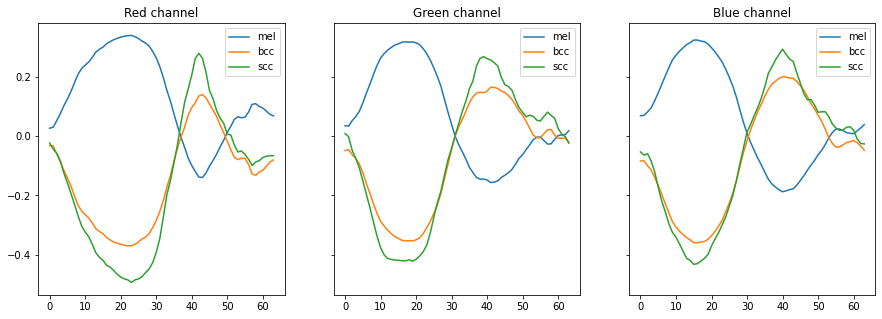

In [ ]:
# -----  RGB Color Histogram after normalization  -----
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_rgb_fd_pp = transform.fit_transform(train_features_all[:, 15:207])

rgb_mel_red = np.mean(train_rgb_fd_pp[train_labels==0, 0:64], axis = 0)
rgb_mel_green = np.mean(train_rgb_fd_pp[train_labels==0, 64:128], axis = 0)
rgb_mel_blue = np.mean(train_rgb_fd_pp[train_labels==0, 128:], axis = 0)

rgb_bcc_red = np.mean(train_rgb_fd_pp[train_labels==1, 0:64], axis = 0)
rgb_bcc_green = np.mean(train_rgb_fd_pp[train_labels==1, 64:128], axis = 0)
rgb_bcc_blue = np.mean(train_rgb_fd_pp[train_labels==1, 128:], axis = 0)

rgb_scc_red = np.mean(train_rgb_fd_pp[train_labels==2, 0:64], axis = 0)
rgb_scc_green = np.mean(train_rgb_fd_pp[train_labels==2, 64:128], axis = 0)
rgb_scc_blue = np.mean(train_rgb_fd_pp[train_labels==2, 128:], axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, rgb_mel_red, label='mel')
axs[0].plot(x, rgb_bcc_red, label='bcc')
axs[0].plot(x, rgb_scc_red, label='scc')
axs[0].legend()
axs[0].set_title("Red channel")

# Green
axs[1].plot(x, rgb_mel_green, label='mel')
axs[1].plot(x, rgb_bcc_green, label='bcc')
axs[1].plot(x, rgb_scc_green, label='scc')
axs[1].legend()
axs[1].set_title("Green channel")

# Blue
axs[2].plot(x, rgb_mel_blue, label='mel')
axs[2].plot(x, rgb_bcc_blue, label='bcc')
axs[2].plot(x, rgb_scc_blue, label='scc')
axs[2].legend()
axs[2].set_title("Blue channel")

plt.subplots_adjust()
plt.show()

###### HSV Histograms

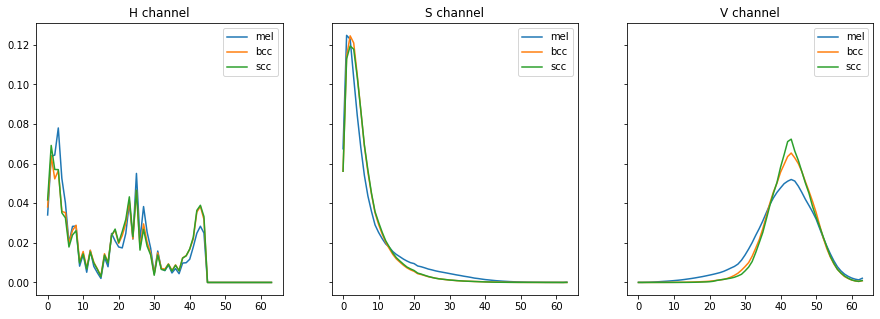

In [ ]:
# -----  HSV Color Histogram before normalization  -----
hsv_mel_h = np.mean(train_features_all[train_labels==0, 207:271], axis = 0)
hsv_mel_s = np.mean(train_features_all[train_labels==0, 271:335], axis = 0)
hsv_mel_v = np.mean(train_features_all[train_labels==0, 335:399], axis = 0)

hsv_bcc_h = np.mean(train_features_all[train_labels==1, 207:271], axis = 0)
hsv_bcc_s = np.mean(train_features_all[train_labels==1, 271:335], axis = 0)
hsv_bcc_v = np.mean(train_features_all[train_labels==1, 335:399], axis = 0)

hsv_scc_h = np.mean(train_features_all[train_labels==2, 207:271], axis = 0)
hsv_scc_s = np.mean(train_features_all[train_labels==2, 271:335], axis = 0)
hsv_scc_v = np.mean(train_features_all[train_labels==2, 335:399], axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, hsv_mel_h, label='mel')
axs[0].plot(x, hsv_bcc_h, label='bcc')
axs[0].plot(x, hsv_scc_h, label='scc')
axs[0].legend()
axs[0].set_title("H channel")

# Green
axs[1].plot(x, hsv_mel_s, label='mel')
axs[1].plot(x, hsv_bcc_s, label='bcc')
axs[1].plot(x, hsv_scc_s, label='scc')
axs[1].legend()
axs[1].set_title("S channel")

# Blue
axs[2].plot(x, hsv_mel_v, label='mel')
axs[2].plot(x, hsv_bcc_v, label='bcc')
axs[2].plot(x, hsv_scc_v, label='scc')
axs[2].legend()
axs[2].set_title("V channel")

plt.subplots_adjust()
plt.show()

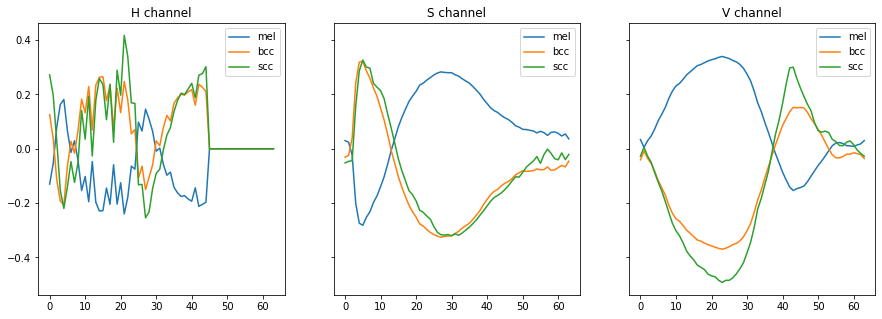

In [ ]:
# -----  HSV Color Histogram after normalization  -----
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_hsv_fd_pp = transform.fit_transform(train_features_all[:,207:399])

hsv_mel_h = np.mean(train_hsv_fd_pp[train_labels==0, 0:64], axis = 0)
hsv_mel_s = np.mean(train_hsv_fd_pp[train_labels==0, 64:128], axis = 0)
hsv_mel_v = np.mean(train_hsv_fd_pp[train_labels==0, 128:], axis = 0)

hsv_bcc_h = np.mean(train_hsv_fd_pp[train_labels==1, 0:64], axis = 0)
hsv_bcc_s = np.mean(train_hsv_fd_pp[train_labels==1, 64:128], axis = 0)
hsv_bcc_v = np.mean(train_hsv_fd_pp[train_labels==1, 128:], axis = 0)

hsv_scc_h = np.mean(train_hsv_fd_pp[train_labels==2, 0:64], axis = 0)
hsv_scc_s = np.mean(train_hsv_fd_pp[train_labels==2, 64:128], axis = 0)
hsv_scc_v = np.mean(train_hsv_fd_pp[train_labels==2, 128:], axis = 0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, hsv_mel_h, label='mel')
axs[0].plot(x, hsv_bcc_h, label='bcc')
axs[0].plot(x, hsv_scc_h, label='scc')
axs[0].legend()
axs[0].set_title("H channel")

# Green
axs[1].plot(x, hsv_mel_s, label='mel')
axs[1].plot(x, hsv_bcc_s, label='bcc')
axs[1].plot(x, hsv_scc_s, label='scc')
axs[1].legend()
axs[1].set_title("S channel")

# Blue
axs[2].plot(x, hsv_mel_v, label='mel')
axs[2].plot(x, hsv_bcc_v, label='bcc')
axs[2].plot(x, hsv_scc_v, label='scc')
axs[2].legend()
axs[2].set_title("V channel")

plt.subplots_adjust()
plt.show()

###### LAB Histograms

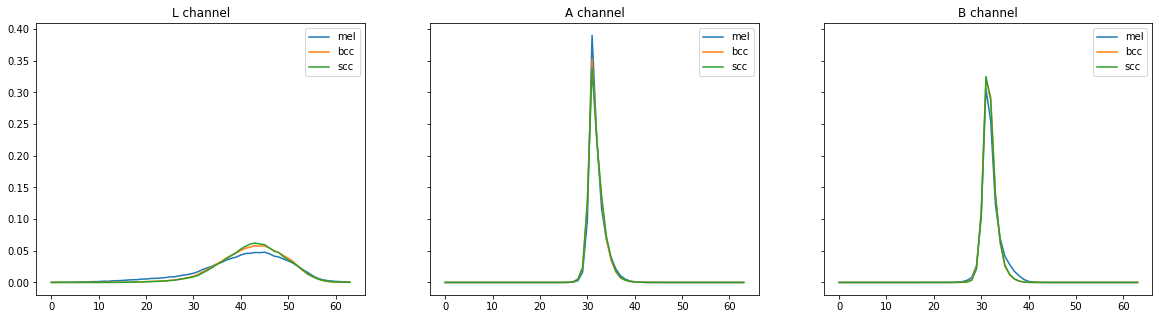

In [ ]:
# -----  LAB Color Histogram before normalization  -----
lab_mel_l = np.mean(train_features_all[train_labels==0, 399:463], axis = 0)
lab_mel_a = np.mean(train_features_all[train_labels==0, 463:527], axis = 0)
lab_mel_b = np.mean(train_features_all[train_labels==0, 527:591], axis = 0)

lab_bcc_l = np.mean(train_features_all[train_labels==1, 399:463], axis = 0)
lab_bcc_a = np.mean(train_features_all[train_labels==1, 463:527], axis = 0)
lab_bcc_b = np.mean(train_features_all[train_labels==1, 527:591], axis = 0)

lab_scc_l = np.mean(train_features_all[train_labels==2, 399:463], axis = 0)
lab_scc_a = np.mean(train_features_all[train_labels==2, 463:527], axis = 0)
lab_scc_b = np.mean(train_features_all[train_labels==2, 527:591], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, lab_mel_l, label='mel')
axs[0].plot(x, lab_bcc_l, label='bcc')
axs[0].plot(x, lab_scc_l, label='scc')
axs[0].legend()
axs[0].set_title("L channel")

# Green
axs[1].plot(x, lab_mel_a, label='mel')
axs[1].plot(x, lab_bcc_a, label='bcc')
axs[1].plot(x, lab_scc_a, label='scc')
axs[1].legend()
axs[1].set_title("A channel")

# Blue
axs[2].plot(x, lab_mel_b, label='mel')
axs[2].plot(x, lab_bcc_b, label='bcc')
axs[2].plot(x, lab_scc_b, label='scc')
axs[2].legend()
axs[2].set_title("B channel")

plt.subplots_adjust()
plt.show()

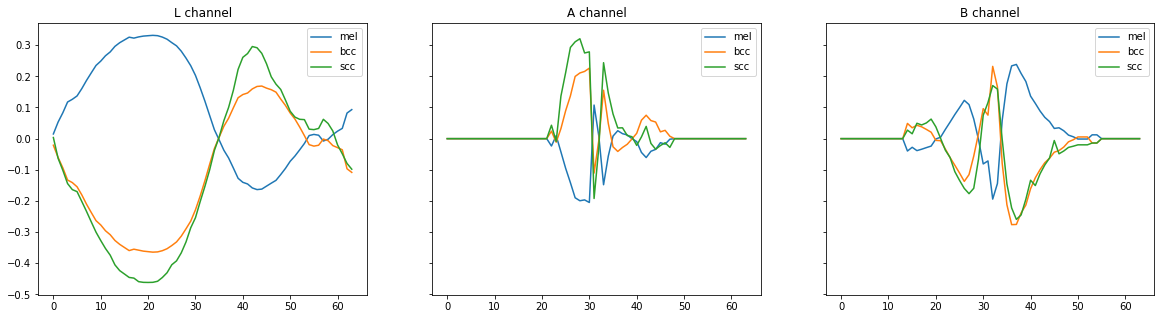

In [ ]:
# -----  LAB Color Histogram after normalization  -----
transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_lab_fd_pp = transform.fit_transform(train_features_all[:, 399:591])

lab_mel_l = np.mean(train_lab_fd_pp[train_labels==0, 0:64], axis = 0)
lab_mel_a = np.mean(train_lab_fd_pp[train_labels==0, 64:128], axis = 0)
lab_mel_b = np.mean(train_lab_fd_pp[train_labels==0, 128:], axis = 0)

lab_bcc_l = np.mean(train_lab_fd_pp[train_labels==1, 0:64], axis = 0)
lab_bcc_a = np.mean(train_lab_fd_pp[train_labels==1, 64:128], axis = 0)
lab_bcc_b = np.mean(train_lab_fd_pp[train_labels==1, 128:], axis = 0)

lab_scc_l = np.mean(train_lab_fd_pp[train_labels==2, 0:64], axis = 0)
lab_scc_a = np.mean(train_lab_fd_pp[train_labels==2, 64:128], axis = 0)
lab_scc_b = np.mean(train_lab_fd_pp[train_labels==2, 128:], axis = 0)


fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
x = range(64)
# Red
axs[0].plot(x, lab_mel_l, label='mel')
axs[0].plot(x, lab_bcc_l, label='bcc')
axs[0].plot(x, lab_scc_l, label='scc')
axs[0].legend()
axs[0].set_title("L channel")

# Green
axs[1].plot(x, lab_mel_a, label='mel')
axs[1].plot(x, lab_bcc_a, label='bcc')
axs[1].plot(x, lab_scc_a, label='scc')
axs[1].legend()
axs[1].set_title("A channel")

# Blue
axs[2].plot(x, lab_mel_b, label='mel')
axs[2].plot(x, lab_bcc_b, label='bcc')
axs[2].plot(x, lab_scc_b, label='scc')
axs[2].legend()
axs[2].set_title("B channel")

plt.subplots_adjust()
plt.show()

###### Color Moments

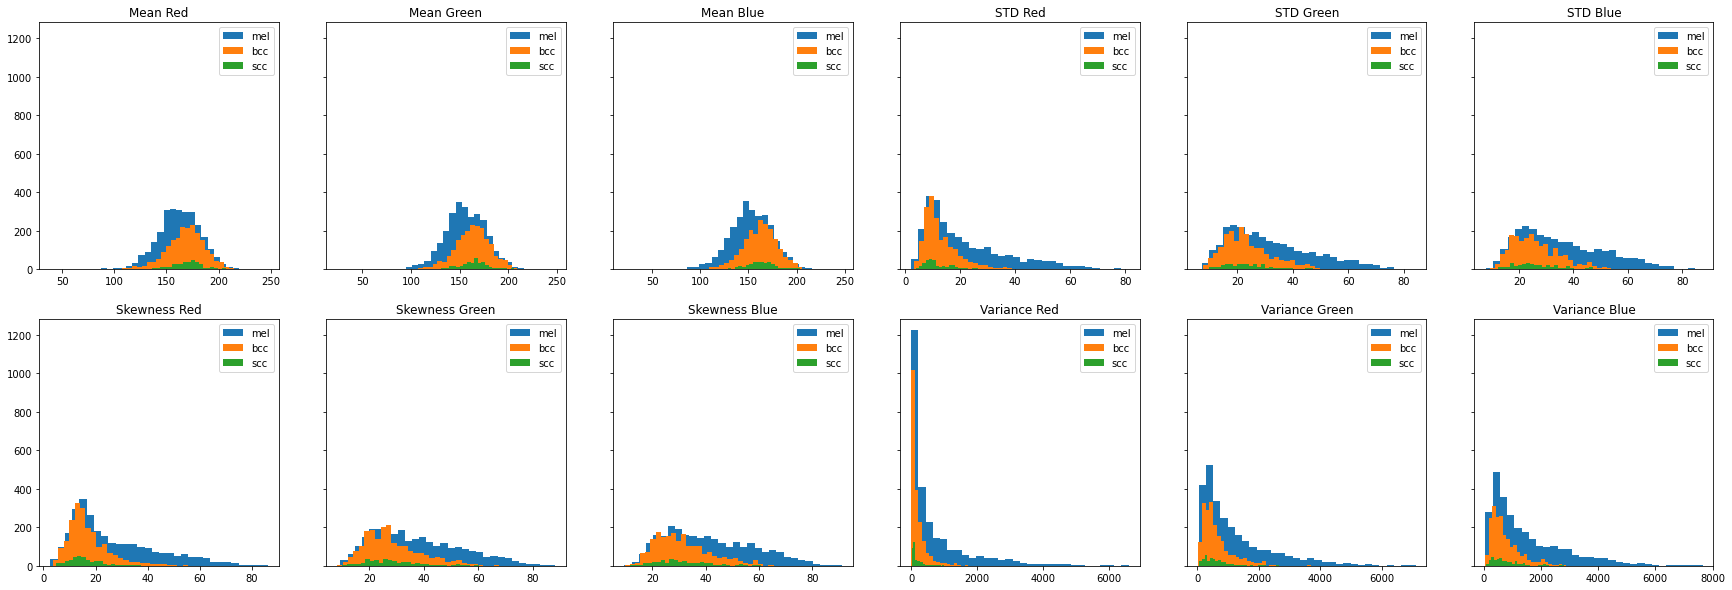

In [ ]:
# -----  Color moments before normalization  -----
titles = ["Mean Red", "Mean Green", "Mean Blue", "STD Red", "STD Green", "STD Blue", "Skewness Red", "Skewness Green", "Skewness Blue", "Variance Red", "Variance Green", "Variance Blue"]
fig, axs = plt.subplots(2, 6, figsize=(30, 10), sharey=True)
bins = 30
col_moments = train_features_all[:, 3:15]
for i in range(0, 12):
  row = int(i/6)
  col = i % 6
  mel_feature = col_moments[train_labels==0, i]
  bcc_feature = col_moments[train_labels==1, i]
  scc_feature = col_moments[train_labels==2, i]
  axs[row, col].hist(mel_feature, bins, histtype='stepfilled' , label = "mel")
  axs[row, col].hist(bcc_feature, bins, histtype='stepfilled' , label = "bcc")
  axs[row, col].hist(scc_feature, bins, histtype='stepfilled' , label = "scc")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

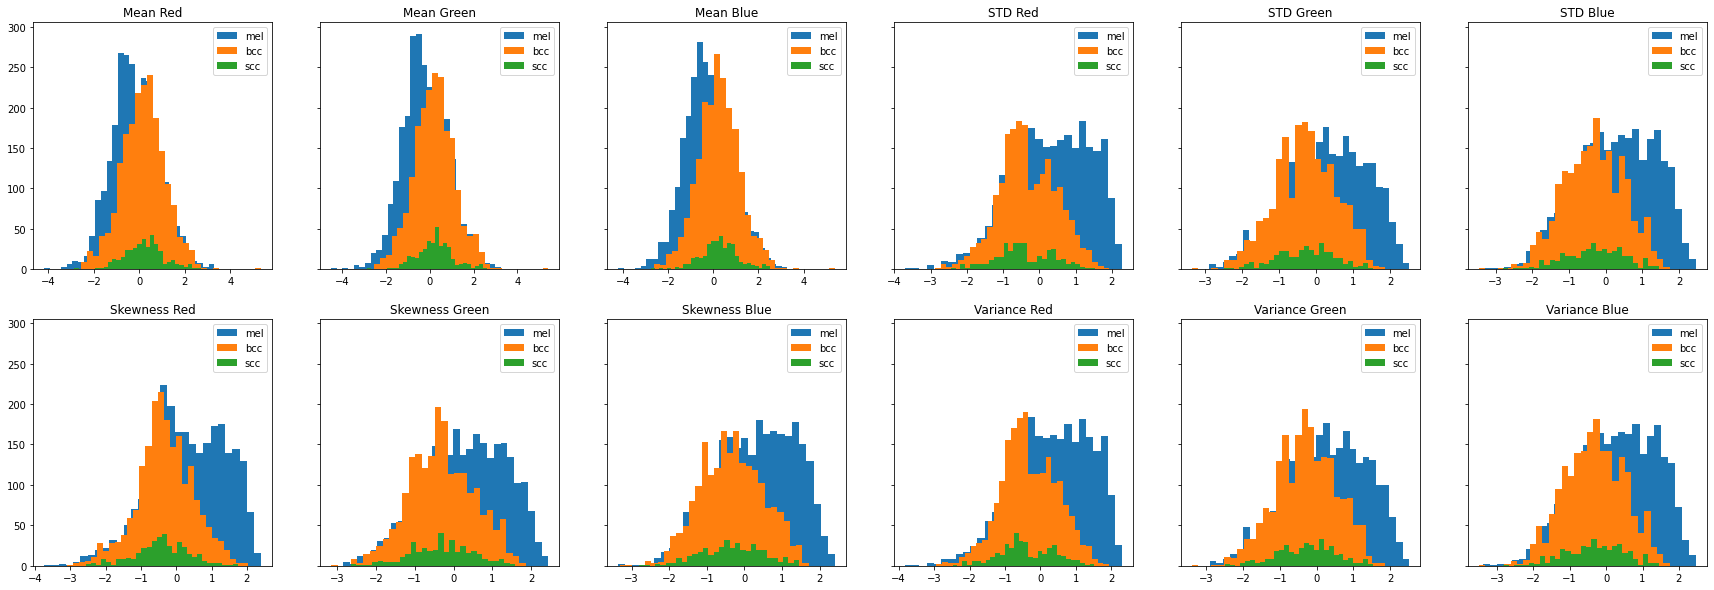

In [ ]:
# -----  Color moments after normalization  -----

transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_color_feature_fd_pp = transform.fit_transform(train_features_all[:, 3:15])

titles = ["Mean Red", "Mean Green", "Mean Blue", "STD Red", "STD Green", "STD Blue", "Skewness Red", "Skewness Green", "Skewness Blue", "Variance Red", "Variance Green", "Variance Blue"]
fig, axs = plt.subplots(2, 6, figsize=(30, 10), sharey=True)
bins = 30
for i in range(0, 12):
  row = int(i/6)
  col = i % 6
  mel_feature = train_color_feature_fd_pp[train_labels==0, i]
  bcc_feature = train_color_feature_fd_pp[train_labels==1, i]
  scc_feature = train_color_feature_fd_pp[train_labels==2, i]
  axs[row, col].hist(mel_feature, bins, histtype='stepfilled' , label = "mel")
  axs[row, col].hist(bcc_feature, bins, histtype='stepfilled' , label = "bcc")
  axs[row, col].hist(scc_feature, bins, histtype='stepfilled' , label = "scc")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

###### GLCM

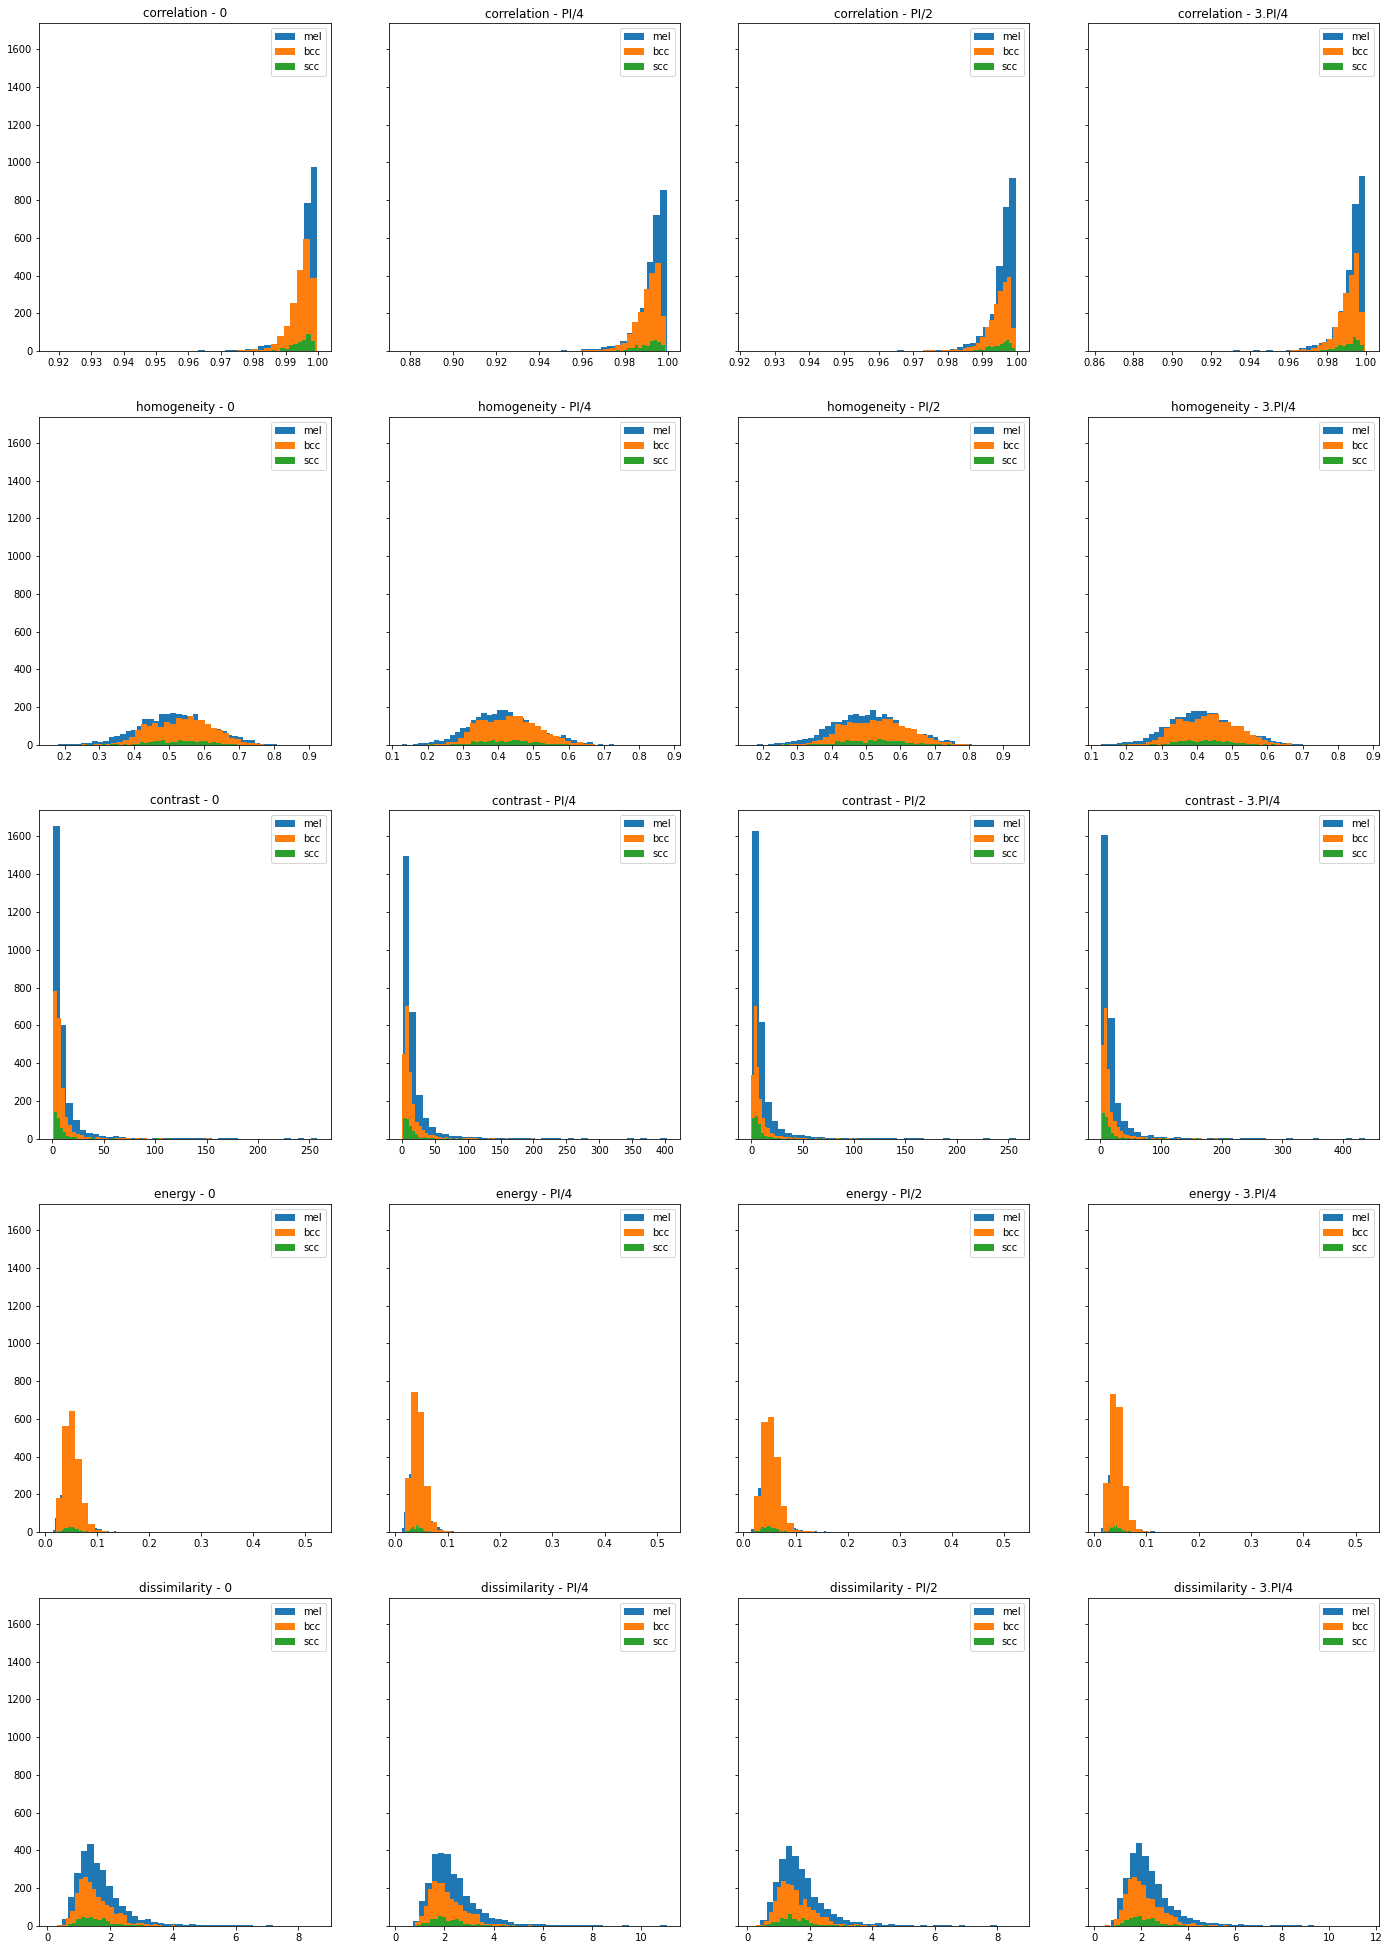

In [ ]:
# -----  GLCM before normalization  -----

angles = ["0", "PI/4", "PI/2", "3.PI/4"]
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
fig, axs = plt.subplots(5, 4, figsize=(24, 35), sharey=True)
bins = 40
glcm_ = train_features_all[:, 622:642]
for i in range(0, 20):
  row = int(i/4)
  col = i % 4
  mel_feature = glcm_[train_labels==0, i]
  bcc_feature = glcm_[train_labels==1, i]
  scc_feature = glcm_[train_labels==2, i]
  axs[row, col].hist(mel_feature, bins, histtype='stepfilled' , label = "mel")
  axs[row, col].hist(bcc_feature, bins, histtype='stepfilled' , label = "bcc")
  axs[row, col].hist(scc_feature, bins, histtype='stepfilled' , label = "scc")
  axs[row, col].legend()

  axs[row, col].set_title(f"{properties[row]} - {angles[col]}")

plt.subplots_adjust()
plt.show()

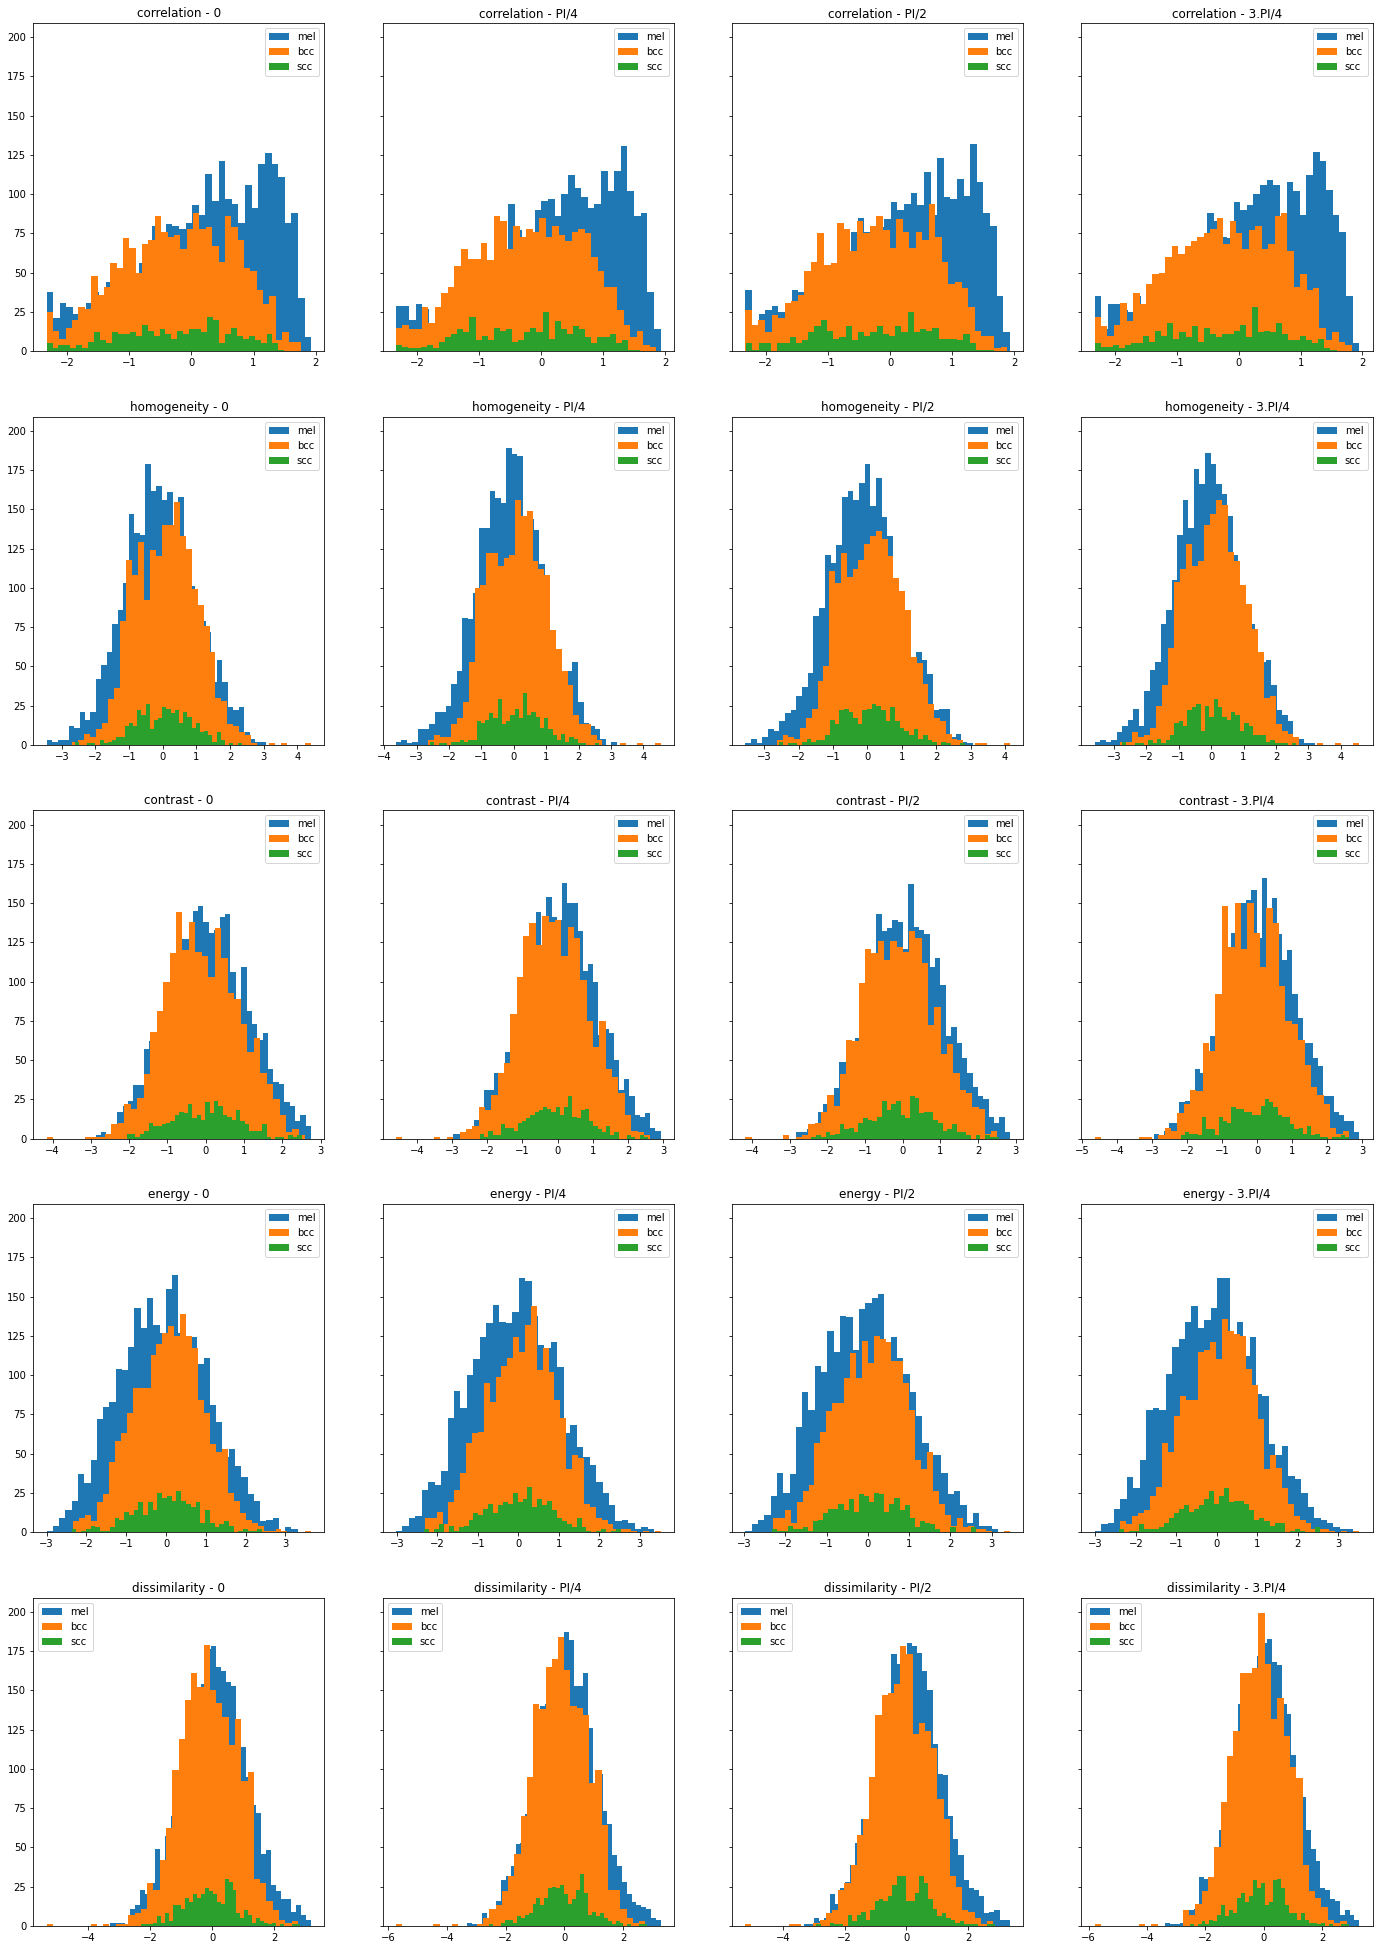

In [ ]:
# -----  GLCM after normalization  -----

transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_glcm_fd_pp = transform.fit_transform(train_features_all[:, 622:642])

angles = ["0", "PI/4", "PI/2", "3.PI/4"]
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
fig, axs = plt.subplots(5, 4, figsize=(24, 35), sharey=True)
bins = 40
for i in range(0, 20):
  row = int(i/4)
  col = i % 4
  mel_feature = train_glcm_fd_pp[train_labels==0, i]
  bcc_feature = train_glcm_fd_pp[train_labels==1, i]
  scc_feature = train_glcm_fd_pp[train_labels==2, i]
  axs[row, col].hist(mel_feature, bins, histtype='stepfilled' , label = "mel")
  axs[row, col].hist(bcc_feature, bins, histtype='stepfilled' , label = "bcc")
  axs[row, col].hist(scc_feature, bins, histtype='stepfilled' , label = "scc")
  axs[row, col].legend()

  axs[row, col].set_title(f"{properties[row]} - {angles[col]}")

plt.subplots_adjust()
plt.show()

###### Haralick

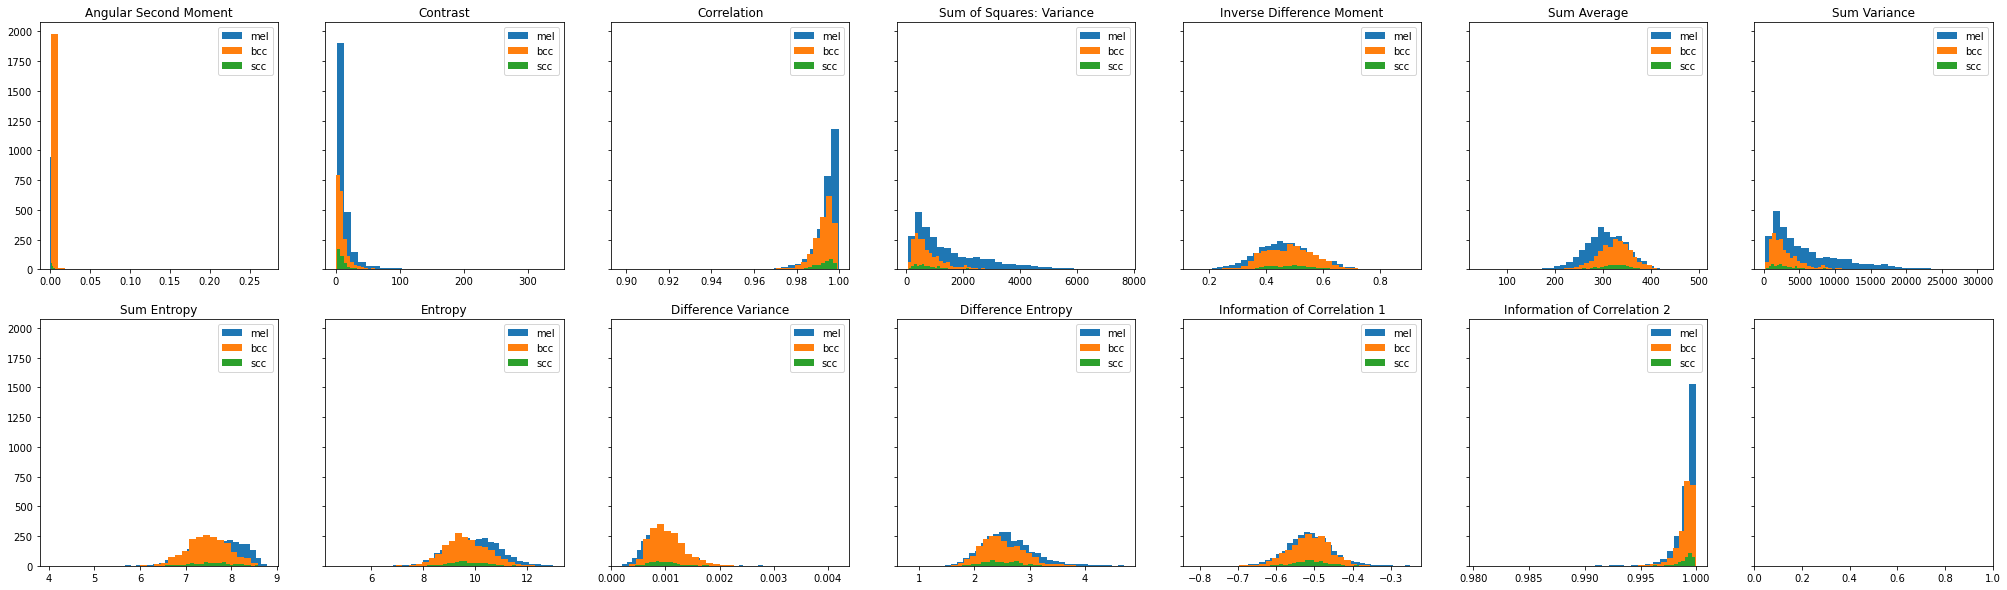

In [ ]:
# -----  Haralick before normalization  -----

titles =["Angular Second Moment",
          "Contrast",
          "Correlation",
          "Sum of Squares: Variance",
          "Inverse Difference Moment",
          "Sum Average",
          "Sum Variance",
          "Sum Entropy",
          "Entropy",
          "Difference Variance",
          "Difference Entropy",
          "Information of Correlation 1",
          "Information of Correlation 2"]
fig, axs = plt.subplots(2, 7, figsize=(35, 10), sharey=True)
bins = 30
haralick_ = train_features_all[:, 609:622]
for i in range(0, 13):
  row = int(i/7)
  col = i % 7
  mel_feature = haralick_[train_labels==0, i]
  bcc_feature = haralick_[train_labels==1, i]
  scc_feature = haralick_[train_labels==2, i]
  axs[row, col].hist(mel_feature, bins, histtype='stepfilled' , label = "mel")
  axs[row, col].hist(bcc_feature, bins, histtype='stepfilled' , label = "bcc")
  axs[row, col].hist(scc_feature, bins, histtype='stepfilled' , label = "scc")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

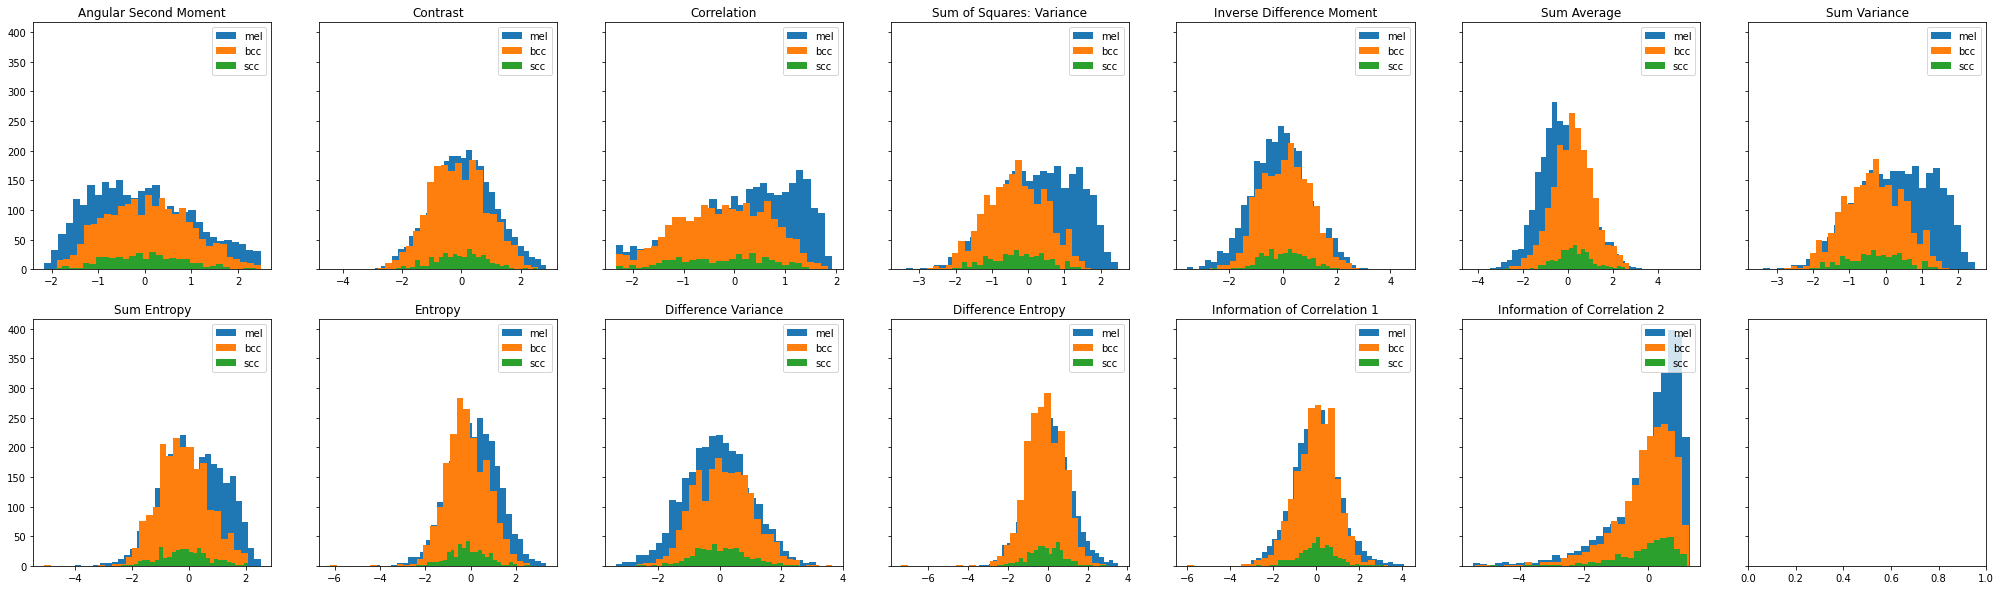

In [ ]:
# -----  Haralick after normalization  -----

transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_haralick_fd_pp = transform.fit_transform(train_features_all[:, 609:622])

titles =["Angular Second Moment",
          "Contrast",
          "Correlation",
          "Sum of Squares: Variance",
          "Inverse Difference Moment",
          "Sum Average",
          "Sum Variance",
          "Sum Entropy",
          "Entropy",
          "Difference Variance",
          "Difference Entropy",
          "Information of Correlation 1",
          "Information of Correlation 2"]
fig, axs = plt.subplots(2, 7, figsize=(35, 10), sharey=True)
bins = 30
for i in range(0, 13):
  row = int(i/7)
  col = i % 7
  mel_feature = train_haralick_fd_pp[train_labels==0, i]
  bcc_feature = train_haralick_fd_pp[train_labels==1, i]
  scc_feature = train_haralick_fd_pp[train_labels==2, i]
  axs[row, col].hist(mel_feature, bins, histtype='stepfilled' , label = "mel")
  axs[row, col].hist(bcc_feature, bins, histtype='stepfilled' , label = "bcc")
  axs[row, col].hist(scc_feature, bins, histtype='stepfilled' , label = "scc")
  axs[row, col].legend()
  axs[row, col].set_title(titles[i])

plt.subplots_adjust()
plt.show()

###### LBP

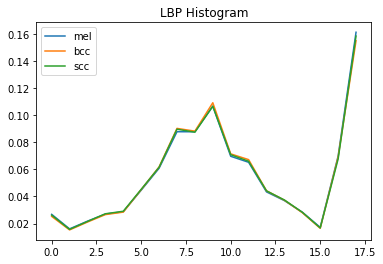

In [ ]:
# -----  LBP before normalization  -----
lbp_mel = np.mean(train_features_all[train_labels==0, 591:609], axis = 0)
lbp_bcc = np.mean(train_features_all[train_labels==1, 591:609], axis = 0)
lbp_scc = np.mean(train_features_all[train_labels==2, 591:609], axis = 0)

plt.plot(lbp_mel, label='mel')
plt.plot(lbp_bcc, label='bcc')
plt.plot(lbp_scc, label='scc')
plt.legend()
plt.title("LBP Histogram")

plt.show()

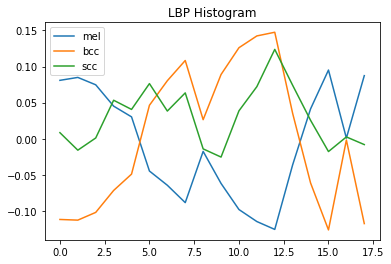

In [ ]:
# -----  LBP after normalization  -----

transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_lbp_fd_pp = transform.fit_transform(train_features_all[:, 591:609])


lbp_mel = np.mean(train_lbp_fd_pp[train_labels==0, :], axis = 0)
lbp_bcc = np.mean(train_lbp_fd_pp[train_labels==1, :], axis = 0)
lbp_scc = np.mean(train_lbp_fd_pp[train_labels==2, :], axis = 0)

plt.plot(lbp_mel, label='mel')
plt.plot(lbp_bcc, label='bcc')
plt.plot(lbp_scc, label='scc')
plt.legend()
plt.title("LBP Histogram")

plt.show()

##### Save Visual features

In [ ]:
train_features_l = np.hstack([train_variegation_fd, 
                              train_color_feature_fd[:, 3:], 
                              train_rgb_fd[:, 64:], 
                              train_hsv_fd, 
                              train_lab_fd, 
                              train_lbp_fd, 
                              train_haralick_fd[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])

val_features_l = np.hstack([val_variegation_fd, 
                            val_color_feature_fd[:, 3:], 
                            val_rgb_fd[:, 64:], 
                            val_hsv_fd, 
                            val_lab_fd, 
                            val_lbp_fd, 
                            val_haralick_fd[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])

In [ ]:
# OverUnderSampling using SMOTE approach :
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_l, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# # Save Shuffled Features :
# if save_path is not None:   
#   with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'wb') as f:
#           pickle.dump(train_features_res, f)
#   print("train_features_res were saved..\n")

#   with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'wb') as f:
#           pickle.dump(train_labels_res, f)
#   print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



### Flat Architecture

#### Baseline: NN + All features

In [ ]:
# Concatenating all Validation features :
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                              val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(val_features_all.shape)

(1270, 642)


In [ ]:
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

In [ ]:
print('train features:', train_features_all.shape)
print('train Labels:', train_labels_all.shape)
print('val features:', val_features_all.shape)
print('val labels:', val_labels.shape)

train features: (5082, 642)
train Labels: (5082,)
val features: (1270, 642)
val labels: (1270,)


In [ ]:
# Training the Baseline model :
strt= time.time()

# Define a PowerTransformer to make the inputs more gaussian-like
transform = PowerTransformer(method='yeo-johnson', standardize=True) 

# set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors = 1)
# baseline_pipe_all = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
baseline_pipe_all = Pipeline(steps=[("pp", transform), ("knn", knn)])

baseline_pipe_all.fit(train_features_all, train_labels_all)
y_pred_baseline_all = baseline_pipe_all.predict(val_features_all)  # Predictions
scores = validate_mc(y_pred_baseline_all, val_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores NN classifier - all training data :', scores)

Total Time = 17.294394731521606
Scores NN classifier - all training data : {'confusion_matrix': array([[529, 101,  48],
       [ 30, 394,  74],
       [ 11,  20,  63]]), 'accuracy': 0.7763779527559055, 'kappa': 0.6213651346868505, 'bma': 0.7472044709308583}


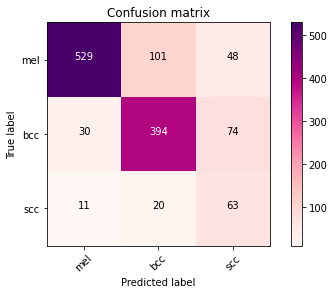

In [ ]:
plot_confusion_matrix(validate_mc(y_pred_baseline_all, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
save_path="/content/drive/MyDrive/CAD_Dataset/Challenge2"
with open(os.path.join(save_path, 'models', 'nn_smund_yeo' + '.pkl'), 'wb') as f:
        # pickle.dump(baseline_pipe_all, f)
print("Model saved..\n")

Model saved..



#### k-NN

##### Fine-tuning 

Here we estimate the best value of the number of neighbors to be used (k) using GridSearchCV and the training set

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

print('train_ft:', train_features_all.shape)
print('train_labels:', train_labels_all.shape)

val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                              val_lbp_fd, val_haralick_fd, val_glcm_fd])
print('val_ft:', val_features_all.shape)
print('val_labels:', val_labels.shape)

train_ft: (5082, 642)
train_labels: (5082,)
val_ft: (1270, 642)
val_labels: (1270,)


In [ ]:
# TRAIN :

# Initialize
strt = time.time()
scaler = StandardScaler()
knn = KNeighborsClassifier()
pipeline = Pipeline(steps=[("pp", transform), ("knn", knn)])
params = {'knn__n_neighbors':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm_a.predict(val_features_all)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Training best_score_ : 0.7715441052404973
Best Parameters {'knn__n_neighbors': 5}
Total Time = 345.38707280158997
Scores KNN classifier : {'confusion_matrix': array([[514,  93,  71],
       [ 40, 326, 132],
       [  6,  17,  71]]), 'accuracy': 0.7173228346456693, 'kappa': 0.5396208963422515, 'bma': 0.7226832390756776}


##### Features A

In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = grid_search.best_params_['knn__n_neighbors'])
scaler = StandardScaler()
knn_lg_a = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = knn_lg_a.predict(val_features_all)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 745.7952046394348
Scores KNN classifier : {'confusion_matrix': array([[514,  93,  71],
       [ 40, 326, 132],
       [  6,  17,  71]]), 'accuracy': 0.7173228346456693, 'kappa': 0.5396208963422515, 'bma': 0.7226832390756776}


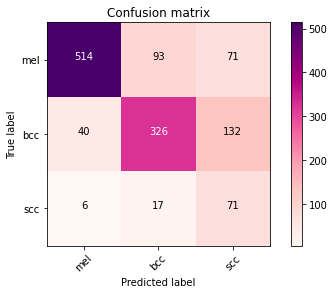

In [ ]:
plot_confusion_matrix(validate_mc(y_pred_baseline_all, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
save_path="/content/drive/MyDrive/CAD_Dataset/Challenge2"
with open(os.path.join(save_path, 'models', 'knn_a_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
train_features_b = np.hstack([train_variegation_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_b.shape)
print(train_labels.shape)
print(val_features_b.shape)
print(val_labels.shape)

(5082, 630)
(5082,)
(1270, 630)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_b, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'sm_und_train_features_B' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'sm_und_train_labels_B' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_B' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_B' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 630)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()
knn_lg_b = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_b.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = knn_lg_b.predict(val_features_b)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 912.816605091095
Scores KNN classifier : {'confusion_matrix': array([[524,  87,  67],
       [ 39, 328, 131],
       [  7,  17,  70]]), 'accuracy': 0.7259842519685039, 'kappa': 0.5518156152647975, 'bma': 0.7253922487161978}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_b_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
train_features_c = np.hstack([train_variegation_fd, train_color_feature_fd, train_hsv_fd, train_lab_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_c.shape)
print(train_labels.shape)
print(val_features_c.shape)
print(val_labels.shape)

(5082, 450)
(5082,)
(1270, 450)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_c, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'sm_und_train_features_C' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'sm_und_train_labels_C' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_C' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_C' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()
knn_lg_c = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_c.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = knn_lg_c.predict(val_features_c)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 1315.5201892852783
Scores KNN classifier : {'confusion_matrix': array([[515,  93,  70],
       [ 40, 328, 130],
       [  7,  20,  67]]), 'accuracy': 0.7165354330708661, 'kappa': 0.5368475649041482, 'bma': 0.7103291720827954}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_c_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
train_features_d = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_d.shape)
print(train_labels.shape)
print(val_features_d.shape)
print(val_labels.shape)

(5082, 450)
(5082,)
(1270, 450)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_d, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# # Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'sm_und_train_features_D' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'sm_und_train_labels_D' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_D' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_D' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()
knn_lg_d = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_d.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = knn_lg_d.predict(val_features_d)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 1361.8468794822693
Scores KNN classifier : {'confusion_matrix': array([[512,  94,  72],
       [ 42, 316, 140],
       [ 12,  16,  66]]), 'accuracy': 0.7039370078740157, 'kappa': 0.5180810437675097, 'bma': 0.6972760180242717}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_d_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
train_features_e = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_lab_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_e.shape)
print(train_labels.shape)
print(val_features_e.shape)
print(val_labels.shape)

(5082, 450)
(5082,)
(1270, 450)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_e, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'sm_und_train_features_E' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'sm_und_train_labels_E' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_E' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_E' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()
knn_lg_e = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_e.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = knn_lg_e.predict(val_features_e)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 1403.3429985046387
Scores KNN classifier : {'confusion_matrix': array([[504, 104,  70],
       [ 47, 328, 123],
       [  7,  21,  66]]), 'accuracy': 0.7070866141732284, 'kappa': 0.5201881710601685, 'bma': 0.7013750098618287}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_e_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
train_features_f = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd]) 
val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])
print(train_features_f.shape)
print(train_labels.shape)
print(val_features_f.shape)
print(val_labels.shape)

(5082, 591)
(5082,)
(1270, 591)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_f, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'sm_und_train_features_F' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'sm_und_train_labels_F' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_F' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_F' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 591)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = grid_search.best_params_['knn__n_neighbors'])
scaler = StandardScaler()
knn_lg_f = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_f.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = knn_lg_f.predict(val_features_f)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 1451.440358877182
Scores KNN classifier : {'confusion_matrix': array([[513, 103,  62],
       [ 51, 310, 137],
       [ 11,  18,  65]]), 'accuracy': 0.6992125984251969, 'kappa': 0.506769039321022, 'bma': 0.6902054965610259}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_f_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
train_features_g = np.hstack([train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_g.shape)
print(train_labels.shape)
print(val_features_g.shape)
print(val_labels.shape)

(5082, 639)
(5082,)
(1270, 639)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = Pipeline(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_g, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'sm_und_train_features_G' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'sm_und_train_labels_G' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_G' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_G' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 639)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()
knn_lg_g = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_g.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = knn_lg_g.predict(val_features_g)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 1505.4898850917816
Scores KNN classifier : {'confusion_matrix': array([[510,  95,  73],
       [ 42, 330, 126],
       [ 10,  17,  67]]), 'accuracy': 0.7141732283464567, 'kappa': 0.532796753767948, 'bma': 0.7092096497456594}


In [ ]:
with open(os.path.join(save_path, 'models', 'knn_g_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_lg_g, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
print('train features:', train_features_all.shape)
print('train Labels:', train_labels_all.shape)

train features: (5082, 642)
train Labels: (5082,)


In [ ]:
strt = time.time()
selector = SelectKBest()
knn = KNeighborsClassifier(n_neighbors = 5)
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("knn", knn)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_kbest = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True) ), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("knn", KNeighborsClassifier(n_neighbors=5))])
knn_kbest.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = knn_kbest.predict(val_features_all)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Training best_score_ : 0.7034624402902143
Best Parameters {'selector__k': 100}
Total Time = 379.4250798225403
Scores KNN classifier : {'confusion_matrix': array([[498,  98,  82],
       [ 61, 277, 160],
       [ 16,  34,  44]]), 'accuracy': 0.6448818897637796, 'kappa': 0.4228924597273105, 'bma': 0.5862744267725518}


2. PCA

In [ ]:
strt = time.time()
pca = PCA()
knn = KNeighborsClassifier(n_neighbors=5)
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("knn", knn)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_pca = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True)), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("knn", KNeighborsClassifier(n_neighbors=5))])
knn_pca.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = knn_pca.predict(val_features_all)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Training best_score_ : 0.7723435327247444
Best Parameters {'pca__n_components': 75}
Total Time = 314.35592103004456
Scores KNN classifier : {'confusion_matrix': array([[529,  82,  67],
       [ 41, 330, 127],
       [  6,  21,  67]]), 'accuracy': 0.7291338582677165, 'kappa': 0.5552044178195161, 'bma': 0.7185508493523457}


3. Model-based selection

In [ ]:
strt = time.time()
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
knn = KNeighborsClassifier(n_neighbors=5)

knn_m_select = Pipeline(steps=[("pp", transform), ("selector", selector_m), ("knn", knn)])
knn_m_select.fit(train_features_all, train_labels_all)

# Evaluation
y_pred = knn_m_select.predict(val_features_all)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 14.6484534740448
Scores KNN classifier : {'confusion_matrix': array([[517,  87,  74],
       [ 35, 358, 105],
       [  6,  20,  68]]), 'accuracy': 0.74251968503937, 'kappa': 0.5761430023637766, 'bma': 0.7349388768278411}


In [ ]:
with open(os.path.join(save_path,'models', 'knn_best_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(knn_m_select, f)
print("Model saved..\n")

Model saved..



##### Features A with StandardScaler

In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = grid_search.best_params_['knn__n_neighbors'])
scaler = StandardScaler()
knn_lg_a = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
knn_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = knn_lg_a.predict(val_features_all)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 745.7952046394348
Scores KNN classifier : {'confusion_matrix': array([[514,  93,  71],
       [ 40, 326, 132],
       [  6,  17,  71]]), 'accuracy': 0.7173228346456693, 'kappa': 0.5396208963422515, 'bma': 0.7226832390756776}


In [ ]:
save_path="/content/drive/MyDrive/CAD_Dataset/Challenge2"
with open(os.path.join(save_path, 'models', 'knn_a_smund' + '.pkl'), 'wb') as f:
        # pickle.dump(knn_lg_a, f)
print("Model saved..\n")

Model saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'rb') as file:
    train_features_l = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'rb') as file:
    train_labels_l = pickle.load(file)

print('train_ft:', train_features_l.shape)
print('train_labels:', train_labels_l.shape)

train_ft: (5082, 552)
train_labels: (5082,)


##### Visually selected features

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'rb') as file:
    train_features_l = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'rb') as file:
    train_labels_l = pickle.load(file)

print('train_ft:', train_features_l.shape)
print('train_labels:', train_labels_l.shape)

train_ft: (5082, 552)
train_labels: (5082,)


In [ ]:
strt = time.time()
knn = KNeighborsClassifier(n_neighbors = 5)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
knn_lg_a = Pipeline(steps=[("pp", transform), ("knn", knn)])
knn_lg_a.fit(train_features_l, train_labels_l)
# Evaluation
y_pred = knn_lg_a.predict(val_features_l)  # Predictions
knn_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', knn_scores)

Total Time = 612.0354201793671
Scores KNN classifier : {'confusion_matrix': array([[514,  94,  70],
       [ 39, 332, 127],
       [ 11,  19,  64]]), 'accuracy': 0.7165354330708661, 'kappa': 0.5355376669605959, 'bma': 0.7018766082972446}


#### XGBoost

##### Fine-tuning

Here we estimate the best values of the parameters of xgboost: n_estimators, max_depth and learning rate, using the train set and GridSearchCV

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

print('train_ft:', train_features_all.shape)
print('train_labels:', train_labels_all.shape)

val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                              val_lbp_fd, val_haralick_fd, val_glcm_fd])
print('val_ft:', val_features_all.shape)
print('val_labels:', val_labels.shape)

train_ft: (5082, 642)
train_labels: (5082,)
val_ft: (1270, 642)
val_labels: (1270,)


In [ ]:
# TRAIN SUBSET

# Initialize
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3)

pipeline = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [3, 5, 7, 9, 13], 'xgb__learning_rate': [0.01, 0.1]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgb_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = xgb_sm_a.predict(val_features_all)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Training best_score_ : 0.6426666666666667
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 1000}
Total Time = 18101.7383146286
Scores XGB classifier : {'confusion_matrix': array([[525,  82,  71],
       [ 35, 330, 133],
       [ 10,  18,  66]]), 'accuracy': 0.7251968503937007, 'kappa': 0.5508957159648198, 'bma': 0.7130381817233159}


##### Features A 

In [ ]:
xgb = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_a = Pipeline(steps=[("pp", transform), ("xgb", xgb)])
xgb_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgb_lg_a.predict(val_features_all)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

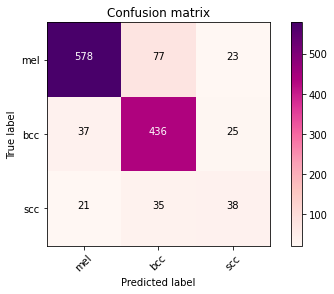

In [ ]:
plot_confusion_matrix(validate_mc(y_pred, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
save_path="/content/drive/MyDrive/CAD_Dataset/Challenge2"
with open(os.path.join(save_path, 'models', 'xgb_a_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_B' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_B' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_b.shape)

train_ft: (5082, 630)
train_labels: (5082,)
val_ft: (1270, 630)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_b = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_b.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_b.predict(val_features_b)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 178.82423639297485
Scores KNN classifier : {'confusion_matrix': array([[1466,  465],
       [ 382, 1483]], dtype=int64), 'accuracy': 0.7768703898840885, 'kappa': 0.5539450851735296}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_b_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_C' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_C' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_c.shape)

train_ft: (5082, 450)
train_labels: (5082,)
val_ft: (1270, 450)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_c = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_c.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_c.predict(val_features_c)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 239.21571803092957
Scores KNN classifier : {'confusion_matrix': array([[1467,  464],
       [ 390, 1475]], dtype=int64), 'accuracy': 0.7750263435194942, 'kappa': 0.5502216159413634}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_c_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_D' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_D' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_d.shape)

train_ft: (5082, 450)
train_labels: (5082,)
val_ft: (1270, 450)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_d = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_d.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_d.predict(val_features_d)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 287.1507785320282
Scores KNN classifier : {'confusion_matrix': array([[1457,  474],
       [ 396, 1469]], dtype=int64), 'accuracy': 0.7708113804004215, 'kappa': 0.5418116373728492}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_d_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_E' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_E' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_e.shape)

train_ft: (5082, 450)
train_labels: (5082,)
val_ft: (1270, 450)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_e = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_e.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_e.predict(val_features_e)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 419.1023874282837
Scores XGB classifier : {'confusion_matrix': array([[570,  89,  19],
       [ 42, 436,  20],
       [ 22,  35,  37]]), 'accuracy': 0.8212598425196851, 'kappa': 0.678615064925799, 'bma': 0.7032756646368314}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_e_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_e, f)
print("Model saved..\n")

##### Features F

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_F' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_F' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_f.shape)

train_ft: (5082, 591)
train_labels: (5082,)
val_ft: (1270, 591)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_f = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_f.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_f.predict(val_features_f)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 425.96545124053955
Scores KNN classifier : {'confusion_matrix': array([[1414,  517],
       [ 402, 1463]], dtype=int64), 'accuracy': 0.7579030558482613, 'kappa': 0.5161695482246034}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_f_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_G' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_G' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_g.shape)

train_ft: (1128, 630)
train_labels: (1128,)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
xgb_lg_g = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_g.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_g.predict(val_features_g)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 582.6496415138245
Scores KNN classifier : {'confusion_matrix': array([[1458,  473],
       [ 383, 1482]], dtype=int64), 'accuracy': 0.7744994731296101, 'kappa': 0.5492343141566218}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_g_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_g, f)
print("Model saved..\n")

Model saved..



##### Features H

In [ ]:
train_features_h = np.hstack([train_variegation_fd, train_rgb_fd, train_lab_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_h = np.hstack([val_variegation_fd, val_rgb_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_h.shape)
print(train_labels.shape)
print(val_features_h.shape)
print(val_labels.shape)

(5082, 438)
(5082,)
(1270, 438)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = pipel(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_h, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_H_xgb' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_H_xgb' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_H_xgb' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_H_xgb' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_h = np.hstack([val_variegation_fd, val_rgb_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)

train_ft: (5082, 438)
train_labels: (5082,)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], learning_rate=grid_search.best_params_['learning_rate'] )
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xgb_lg_h = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_h.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xgb_lg_h.predict(val_features_h)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 287.46002864837646
Scores XGB classifier : {'confusion_matrix': array([[580,  77,  21],
       [ 39, 430,  29],
       [ 21,  35,  38]]), 'accuracy': 0.8251968503937008, 'kappa': 0.687008765619588, 'bma': 0.7077221205162078}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_h_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_h, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
selector = SelectKBest()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("xgb", xgboost)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgb_kbest = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True) ), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("xgb", xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] ))])
xgb_kbest.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = xgb_kbest.predict(val_features_all)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Training best_score_ : 0.76
Best Parameters {'selector__k': 50}
Total Time = 3.8494489192962646
Scores KNN classifier : {'confusion_matrix': array([[1536,  395],
       [ 436, 1429]], dtype=int64), 'accuracy': 0.7810853530031612, 'kappa': 0.5618737086669248}


2. PCA

In [ ]:
strt = time.time()
pca = PCA()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("xgb", xgboost)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgb_pca = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True) ), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("xgb", xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] ))])
xgb_pca.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgb_pca.predict(val_features_all)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Training best_score_ : 0.7395000000000002
Best Parameters {'pca__n_components': 50}
Total Time = 6.131984233856201
Scores KNN classifier : {'confusion_matrix': array([[1504,  427],
       [ 426, 1439]], dtype=int64), 'accuracy': 0.7752897787144363, 'kappa': 0.550447776776918}


3. Model-based selection

In [ ]:
strt = time.time()
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['xgb__n_estimators'], max_depth=grid_search.best_params_['xgb__max_depth'], learning_rate=grid_search.best_params_['xgb__learning_rate'] )

xgb_m_select = Pipeline(steps=[("pp", transform), ("selector", selector_m), ("xgb", xgboost)])
xgb_m_select.fit(train_features_all, train_labels_all)

# Evaluation
y_pred = xgb_m_select.predict(val_features_all)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 5.16645073890686
Scores KNN classifier : {'confusion_matrix': array([[1530,  401],
       [ 415, 1450]], dtype=int64), 'accuracy': 0.7850368809272918, 'kappa': 0.5698885791783225}


In [ ]:
with open(os.path.join(save_path, 'models', 'xgb_best_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_m_select, f)
print("Model saved..\n")

Model saved..



##### Features A with StandardScaler

In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], learning_rate=grid_search.best_params_['learning_rate'] )
scaler = StandardScaler()
xgb_lg_a = Pipeline(steps=[("scaler", scaler), ("xgb", xgboost)])
xgb_lg_a.fit(train_features_all, train_labels)
# Evaluation
y_pred = xgb_lg_a.predict(val_features_all)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 15.897425651550293
Scores KNN classifier : {'confusion_matrix': array([[1457,  474],
       [ 385, 1480]], dtype=int64), 'accuracy': 0.773709167544784, 'kappa': 0.5476503862659992}


In [ ]:
save_path="/content/drive/MyDrive/CAD_Dataset/Challenge2"
with open(os.path.join(save_path, 'models', 'xgb_a_smund' + '.pkl'), 'wb') as f:
        pickle.dump(xgb_lg_a, f)
print("Model saved..\n")

Model saved..



##### Visually selected features

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'rb') as file:
    train_features_l = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'rb') as file:
    train_labels_l = pickle.load(file)

print('train_ft:', train_features_l.shape)
print('train_labels:', train_labels_l.shape)

train_ft: (5082, 552)
train_labels: (5082,)


In [ ]:
strt = time.time()
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=500, max_depth=7, learning_rate=0.1)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xgb_lg_a = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])
xgb_lg_a.fit(train_features_l, train_labels_l)
# Evaluation
y_pred = xgb_lg_a.predict(val_features_l)  # Predictions
xgb_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XGB classifier :', xgb_scores)

Total Time = 1168.0881865024567
Scores XGB classifier : {'confusion_matrix': array([[576,  84,  18],
       [ 37, 425,  36],
       [ 19,  40,  35]]), 'accuracy': 0.815748031496063, 'kappa': 0.6707642947987893, 'bma': 0.6917705340914275}


#### SVM

##### Fine-tuning

Here we estimate the best values of the parameter C of SVM, using the train set and GridSearchCV

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

print('train_ft:', train_features_all.shape)
print('train_labels:', train_labels_all.shape)

val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                              val_lbp_fd, val_haralick_fd, val_glcm_fd])
print('val_ft:', val_features_all.shape)
print('val_labels:', val_labels.shape)

train_ft: (5082, 642)
train_labels: (5082,)
val_ft: (1270, 642)
val_labels: (1270,)


In [ ]:
# TRAIN SUBSET 

# Initialize
strt = time.time()
model = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42)
pipeline = Pipeline(steps=[("pp", transform), ("svm", model)])
params = {'svm__kernel':['rbf'], 'svm__C': [0.01, 0.5, 1, 5, 10, 11] }  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm_a.predict(val_features_all)  # Predictions
scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores KNN classifier :', scores)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training best_score_ : 0.8461160275319568
Best Parameters {'svm__C': 11, 'svm__kernel': 'rbf'}
Total Time = 810.3820586204529
Scores KNN classifier : {'confusion_matrix': array([[563,  95,  20],
       [ 50, 399,  49],
       [ 18,  27,  49]]), 'accuracy': 0.7960629921259843, 'kappa': 0.6403296986874161, 'bma': 0.7176216319492493}


##### Features A 

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C= grid_search.best_params_['svm__C'])

svm_lg_a = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = svm_lg_a.predict(val_features_all)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 1148.0244653224945
Scores SVM classifier : {'confusion_matrix': array([[563,  95,  20],
       [ 50, 399,  49],
       [ 18,  27,  49]]), 'accuracy': 0.7960629921259843, 'kappa': 0.6403296986874161, 'bma': 0.7176216319492493}


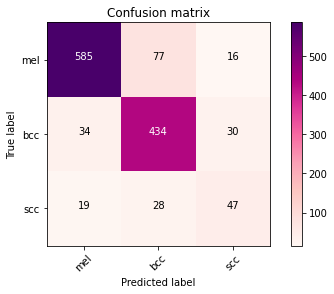

In [ ]:
plot_confusion_matrix(validate_mc(y_pred, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
with open(os.path.join(save_path, 'models', 'svm_a_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_B' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_B' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_b.shape)

train_ft: (5082, 630)
train_labels: (5082,)
val_ft: (1270, 630)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])
svm_lg_b = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_b.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_b.predict(val_features_b)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 1342.2960240840912
Scores SVM classifier : {'confusion_matrix': array([[559,  92,  27],
       [ 46, 394,  58],
       [ 18,  35,  41]]), 'accuracy': 0.7826771653543307, 'kappa': 0.6186700667098924, 'bma': 0.6839395490705683}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_b_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_C' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_C' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_c.shape)

train_ft: (5082, 450)
train_labels: (5082,)
val_ft: (1270, 450)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])
svm_lg_c = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_c.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_c.predict(val_features_c)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 1451.0397522449493
Scores SVM classifier : {'confusion_matrix': array([[559,  94,  25],
       [ 40, 397,  61],
       [ 19,  26,  49]]), 'accuracy': 0.7913385826771654, 'kappa': 0.6356658800095265, 'bma': 0.7143163755253236}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_c_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_D' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_D' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_d.shape)

train_ft: (5082, 450)
train_labels: (5082,)
val_ft: (1270, 450)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])
svm_lg_d = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_d.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_d.predict(val_features_d)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 2140.133309364319
Scores SVM classifier : {'confusion_matrix': array([[565,  92,  21],
       [ 45, 398,  55],
       [ 17,  32,  45]]), 'accuracy': 0.7937007874015748, 'kappa': 0.6369306377555475, 'bma': 0.7037511749124156}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_d_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_E' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_E' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_e.shape)

train_ft: (5082, 450)
train_labels: (5082,)
val_ft: (1270, 450)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])
svm_lg_e = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_e.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_e.predict(val_features_e)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 2328.76021194458
Scores SVM classifier : {'confusion_matrix': array([[548, 100,  30],
       [ 42, 401,  55],
       [ 16,  35,  43]]), 'accuracy': 0.7811023622047244, 'kappa': 0.6175162934202316, 'bma': 0.690309093021808}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_e_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_F' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_F' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_f.shape)

train_ft: (5082, 591)
train_labels: (5082,)
val_ft: (1270, 591)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])
svm_lg_f = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_f.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_f.predict(val_features_f)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 2599.3329606056213
Scores SVM classifier : {'confusion_matrix': array([[550,  93,  35],
       [ 48, 386,  64],
       [ 20,  34,  40]]), 'accuracy': 0.768503937007874, 'kappa': 0.596501238442286, 'bma': 0.6706139186760222}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_f_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_G' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_G' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_g.shape)

train_ft: (5082, 639)
train_labels: (5082,)
val_ft: (1270, 639)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])
svm_lg_g = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_g.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_g.predict(val_features_g)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 2692.9397764205933
Scores SVM classifier : {'confusion_matrix': array([[558,  93,  27],
       [ 47, 399,  52],
       [ 19,  32,  43]]), 'accuracy': 0.7874015748031497, 'kappa': 0.6262295510830513, 'bma': 0.6938868257817563}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_g_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_g, f)
print("Model saved..\n")

Model saved..



##### Features H

In [ ]:
train_features_h = np.hstack([train_variegation_fd, train_hsv_fd, train_lab_fd, 
                              train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_h = np.hstack([val_variegation_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])
print(train_features_h.shape)
print(train_labels.shape)
print(val_features_h.shape)
print(val_labels.shape)

(5082, 438)
(5082,)
(1270, 438)
(1270,)


In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2713, 1: 1993, 2: 1694}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
steps = [('o', sm), ('u', under)]
pipeline = pipel(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(train_features_h, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_H_svm' + '.pkl'), 'wb') as f:
          pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_H_svm' + '.pkl'), 'wb') as f:
          pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 2713, 1: 1993, 2: 376})
Resampled dataset shape: Counter({0: 1694, 1: 1694, 2: 1694})
train_features_res were saved..

train_labels_res were saved..



In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_H_svm' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_H_svm' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_h = np.hstack([val_variegation_fd, val_hsv_fd, val_lab_fd, 
                            val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_h.shape)

train_ft: (5082, 438)
train_labels: (5082,)
val_ft: (1270, 438)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel=grid_search.best_params_['svm__kernel'], C=grid_search.best_params_['svm__C'])

svm_lg_h = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_h.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_lg_h.predict(val_features_h)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 34.311336040496826
Scores SVM classifier : {'confusion_matrix': array([[590,  73,  15],
       [ 38, 426,  34],
       [ 16,  31,  47]]), 'accuracy': 0.837007874015748, 'kappa': 0.70896840930628, 'bma': 0.7418760588075014}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_h_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_h, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
selector = SelectKBest()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("svm", svm)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_kbest = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True)), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("svm", SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)
)])
svm_kbest.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = svm_kbest.predict(val_features_all)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Training best_score_ : 0.7128949864143873
Best Parameters {'selector__k': 100}
Total Time = 289.0236430168152
Scores SVM classifier : {'confusion_matrix': array([[522,  80,  76],
       [ 37, 328, 133],
       [ 11,  28,  55]]), 'accuracy': 0.7125984251968503, 'kappa': 0.5291499406803075, 'bma': 0.6712174751853709}


2. PCA

In [ ]:
strt = time.time()
pca = PCA()
transform = PowerTransformer(method='yeo-johnson', standardize=True)
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("svm", svm)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_sm, train_labels_sm)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_pca = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True)), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("svm", SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)
)])
svm_pca.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = svm_pca.predict(val_features_c)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Training best_score_ : 0.8846974219336371
Best Parameters {'pca__n_components': 100}
Total Time = 635.595894575119
Scores SVM classifier : {'confusion_matrix': array([[609,  63,   6],
       [ 50, 428,  20],
       [ 25,  24,  45]]), 'accuracy': 0.8519685039370078, 'kappa': 0.7305204039710882, 'bma': 0.7454637479183034}


3. Model-based selection

In [ ]:
strt = time.time()
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)

svm_m_select = Pipeline(steps=[("pp", transform), ("selector", selector_m), ("svm", svm)])
svm_m_select.fit(train_features_all, train_labels_all)

# Evaluation
y_pred = svm_m_select.predict(val_features_all)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 15.711357116699219
Scores SVM classifier : {'confusion_matrix': array([[572,  83,  23],
       [ 53, 388,  57],
       [ 20,  31,  43]]), 'accuracy': 0.789763779527559, 'kappa': 0.6290173648187372, 'bma': 0.6934070304944123}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_best_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(svm_pca, f)
print("Model saved..\n")

Model saved..



##### Features A with StandardScaler

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C= grid_search.best_params_['svm__C'])
scaler = StandardScaler()
svm_lg_a = Pipeline(steps=[("scaler", scaler), ("svm", svm)])
svm_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = svm_lg_a.predict(val_features_all)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 1148.0244653224945
Scores SVM classifier : {'confusion_matrix': array([[563,  95,  20],
       [ 50, 399,  49],
       [ 18,  27,  49]]), 'accuracy': 0.7960629921259843, 'kappa': 0.6403296986874161, 'bma': 0.7176216319492493}


In [ ]:
with open(os.path.join(save_path, 'models', 'svm_a_smund' + '.pkl'), 'wb') as f:
        pickle.dump(svm_lg_a, f)
print("Model saved..\n")

Model saved..



##### Visually selected features

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'rb') as file:
    train_features_l = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'rb') as file:
    train_labels_l = pickle.load(file)

print('train_ft:', train_features_l.shape)
print('train_labels:', train_labels_l.shape)

train_ft: (5082, 552)
train_labels: (5082,)


In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C= 11)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
svm_lg_a = Pipeline(steps=[("pp", transform), ("svm", svm)])
svm_lg_a.fit(train_features_l, train_labels_l)
# Evaluation
y_pred = svm_lg_a.predict(val_features_l)  # Predictions
svm_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores SVM classifier :', svm_scores)

Total Time = 1260.126119852066
Scores SVM classifier : {'confusion_matrix': array([[579,  80,  19],
       [ 32, 430,  36],
       [ 18,  30,  46]]), 'accuracy': 0.8307086614173228, 'kappa': 0.6992920891958803, 'bma': 0.7355992727578865}


#### Random Forest

##### Fine-tuning

Here we estimate the best values of the parameters of RandomForest: n_estimators, max_depth and criterion, using the train set and GridSearchCV.

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

print('train_ft:', train_features_all.shape)
print('train_labels:', train_labels_all.shape)

val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                              val_lbp_fd, val_haralick_fd, val_glcm_fd])
print('val_ft:', val_features_all.shape)
print('val_labels:', val_labels.shape)

train_ft: (5082, 642)
train_labels: (5082,)
val_ft: (1270, 642)
val_labels: (1270,)


In [ ]:
# TRAIN :

# Initialize
strt = time.time()
rf = RandomForestClassifier()  # RF classifier
pipeline = Pipeline(steps=[("pp", transform), ("rf", rf)])
params = {'rf__n_estimators':[100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [3, 5, 7, 9, 13]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm_a.predict(val_features_all)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Training best_score_ : 0.8474920435437794
Best Parameters {'rf__criterion': 'entropy', 'rf__max_depth': 13, 'rf__n_estimators': 500}
Total Time = 6842.004483938217
Scores RF classifier : {'confusion_matrix': array([[564,  84,  30],
       [ 45, 391,  62],
       [ 17,  37,  40]]), 'accuracy': 0.7834645669291339, 'kappa': 0.6208288458866037, 'bma': 0.6808436280740864}


##### Features A 

In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators=grid_search.best_params_['rf__n_estimators'], criterion=grid_search.best_params_['rf__criterion'], max_depth=grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_a = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = rf_lg_a.predict(val_features_all)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 99.11311173439026
Scores RF classifier : {'confusion_matrix': array([[563,  86,  29],
       [ 44, 394,  60],
       [ 18,  36,  40]]), 'accuracy': 0.7850393700787401, 'kappa': 0.6231642421765632, 'bma': 0.6823600181180379}


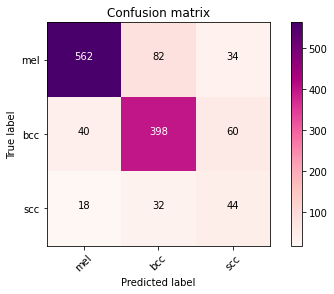

In [ ]:
plot_confusion_matrix(validate_mc(y_pred, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
with open(os.path.join(save_path, 'models', 'rf_a_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_B' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_B' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_b.shape)

train_ft: (5082, 630)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators = grid_search.best_params_['rf__n_estimators'], criterion = grid_search.best_params_['rf__criterion'], max_depth = grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_b = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_b.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = rf_lg_b.predict(val_features_b)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 7689.51204252243
Scores RF classifier : {'confusion_matrix': array([[553,  86,  39],
       [ 42, 386,  70],
       [ 18,  31,  45]]), 'accuracy': 0.7748031496062993, 'kappa': 0.6104110623436689, 'bma': 0.6898193413836101}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_b_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_C' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_C' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_c.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators = grid_search.best_params_['rf__n_estimators'], criterion = grid_search.best_params_['rf__criterion'], max_depth = grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_c = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_c.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = rf_lg_c.predict(val_features_c)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 7792.036196708679
Scores RF classifier : {'confusion_matrix': array([[566,  91,  21],
       [ 40, 396,  62],
       [ 18,  35,  41]]), 'accuracy': 0.789763779527559, 'kappa': 0.6307078073133119, 'bma': 0.6887197317481815}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_c_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_D' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_D' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_d.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators = grid_search.best_params_['rf__n_estimators'], criterion = grid_search.best_params_['rf__criterion'], max_depth = grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_d = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_d.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = rf_lg_d.predict(val_features_d)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 7918.860128164291
Scores RF classifier : {'confusion_matrix': array([[557,  89,  32],
       [ 44, 390,  64],
       [ 16,  34,  44]]), 'accuracy': 0.7803149606299212, 'kappa': 0.6173294165928678, 'bma': 0.6909171866024318}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_d_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_E' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_E' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_e.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators = grid_search.best_params_['rf__n_estimators'], criterion = grid_search.best_params_['rf__criterion'], max_depth = grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_e = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_e.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = rf_lg_e.predict(val_features_e)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 8010.585558176041
Scores RF classifier : {'confusion_matrix': array([[547,  96,  35],
       [ 47, 387,  64],
       [ 17,  31,  46]]), 'accuracy': 0.7716535433070866, 'kappa': 0.6035692758115905, 'bma': 0.6910849322098537}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_e_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_F' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_F' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_f.shape)

train_ft: (5082, 591)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators = grid_search.best_params_['rf__n_estimators'], criterion = grid_search.best_params_['rf__criterion'], max_depth = grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_f = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_f.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = rf_lg_f.predict(val_features_f)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 8122.304963350296
Scores RF classifier : {'confusion_matrix': array([[545,  96,  37],
       [ 45, 389,  64],
       [ 16,  36,  42]]), 'accuracy': 0.768503937007874, 'kappa': 0.598141060688901, 'bma': 0.6772559389632842}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_f_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_G' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_G' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_g.shape)

train_ft: (5082, 639)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators = grid_search.best_params_['rf__n_estimators'], criterion = grid_search.best_params_['rf__criterion'], max_depth = grid_search.best_params_['rf__max_depth'])  # RF classifier
rf_lg_g = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_g.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = rf_lg_g.predict(val_features_g)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 8229.107575654984
Scores RF classifier : {'confusion_matrix': array([[559,  87,  32],
       [ 42, 397,  59],
       [ 17,  34,  43]]), 'accuracy': 0.7866141732283465, 'kappa': 0.6272537841045946, 'bma': 0.6930397797806428}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_g_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_g, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
selector = SelectKBest()
rf = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 13)  # RF classifier
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("rf", rf)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_kbest = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True)), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("rf", RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 13))])
rf_kbest.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = rf_kbest.predict(val_features_all)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Training best_score_ : 0.8219196732471069
Best Parameters {'selector__k': 100}
Total Time = 644.8868865966797
Scores RF classifier : {'confusion_matrix': array([[555,  88,  35],
       [ 43, 381,  74],
       [ 19,  39,  36]]), 'accuracy': 0.7653543307086614, 'kappa': 0.5921591447907237, 'bma': 0.6555410117215237}


2. PCA

In [ ]:
strt = time.time()
pca = PCA()
rf = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 13)  # RF classifier
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("rf", rf)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_pca = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True)), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("rf", RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 13))])
rf_pca.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = rf_pca.predict(val_features_all)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Training best_score_ : 0.816600047709646
Best Parameters {'pca__n_components': 100}
Total Time = 730.8091292381287
Scores RF classifier : {'confusion_matrix': array([[541,  97,  40],
       [ 52, 368,  78],
       [ 22,  33,  39]]), 'accuracy': 0.7464566929133858, 'kappa': 0.5617723711057387, 'bma': 0.6505948478530956}


3. Model-based selection

In [ ]:
strt = time.time()
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
rf = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 13)  # RF classifier

rf_m_select = Pipeline(steps=[("pp", transform), ("selector", selector_m), ("rf", rf)])
rf_m_select.fit(train_features_all, train_labels_all)

# Evaluation
y_pred = rf_m_select.predict(val_features_all)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 39.61692547798157
Scores RF classifier : {'confusion_matrix': array([[556,  86,  36],
       [ 44, 400,  54],
       [ 15,  38,  41]]), 'accuracy': 0.7850393700787401, 'kappa': 0.6242294052872985, 'bma': 0.6864806870739092}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_best_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(rf_m_select, f)
print("Model saved..\n")

Model saved..



##### Features A with StandardScaler

In [ ]:
strt = time.time
rf = RandomForestClassifier(n_estimators=grid_search.best_params_['rf__n_estimators'], criterion=grid_search.best_params_['rf__criterion'], max_depth=grid_search.best_params_['rf__max_depth'])  # RF classifier
scaler = StandardScaler()
rf_lg_a = Pipeline(steps=[("scaler", scaler), ("rf", rf)])
rf_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = rf_lg_a.predict(val_features_all)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 7461.20260477066
Scores RF classifier : {'confusion_matrix': array([[562,  87,  29],
       [ 47, 387,  64],
       [ 16,  35,  43]]), 'accuracy': 0.7811023622047244, 'kappa': 0.6174383779543258, 'bma': 0.6878212656059498}


In [ ]:
with open(os.path.join(save_path, 'models', 'rf_a_smund' + '.pkl'), 'wb') as f:
        pickle.dump(rf_lg_a, f)
print("Model saved..\n")

Model saved..



##### Visually selected features

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'rb') as file:
    train_features_l = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'rb') as file:
    train_labels_l = pickle.load(file)

print('train_ft:', train_features_l.shape)
print('train_labels:', train_labels_l.shape)

train_ft: (5082, 552)
train_labels: (5082,)


In [ ]:
strt = time.time()
rf = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=13)  # RF classifier
transform = PowerTransformer(method='yeo-johnson', standardize=True)
rf_lg_a = Pipeline(steps=[("pp", transform), ("rf", rf)])
rf_lg_a.fit(train_features_l, train_labels_l)
# Evaluation
y_pred = rf_lg_a.predict(val_features_l)  # Predictions
rf_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores RF classifier :', rf_scores)

Total Time = 1332.4647526741028
Scores RF classifier : {'confusion_matrix': array([[556,  94,  28],
       [ 43, 396,  59],
       [ 17,  34,  43]]), 'accuracy': 0.7834645669291339, 'kappa': 0.6212367690439007, 'bma': 0.6908955094841174}


#### Extra Trees

##### Fine-tuning

Here we estimate the best values of the parameters of ExtraTreeClassifier: n_estimators, max_depth and criterion, using the train set and GridSearchCV.

##### Features A

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

print('train_ft:', train_features_all.shape)
print('train_labels:', train_labels_all.shape)

val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, 
                              val_lbp_fd, val_haralick_fd, val_glcm_fd])
print('val_ft:', val_features_all.shape)
print('val_labels:', val_labels.shape)

train_ft: (5082, 642)
train_labels: (5082,)
val_ft: (1270, 642)
val_labels: (1270,)


In [ ]:
# TRAIN SUBSET

# Initialize
strt = time.time()
xt = ExtraTreesClassifier()  # XT classifier
pipeline = Pipeline(steps=[("pp", transform), ("xt", xt)])
params = {'xt__n_estimators':[100, 500, 1000, 2000], 'xt__criterion' : ['entropy','gini'], 'xt__max_depth': [3, 5, 7, 9, 13]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xt_sm_a = grid_search.best_estimator_

# Evaluation
y_pred = xt_sm_a.predict(val_features_all)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Training best_score_ : 0.6275555555555555
Best Parameters {'xt__criterion': 'entropy', 'xt__max_depth': 13, 'xt__n_estimators': 1000}
Total Time = 420.9079418182373
Scores XT classifier : {'confusion_matrix': array([[514,  81,  83],
       [ 44, 312, 142],
       [ 11,  23,  60]]), 'accuracy': 0.6976377952755906, 'kappa': 0.5089612952595755, 'bma': 0.6743053302773637}


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_a = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = xt_lg_a.predict(val_features_all)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 8289.870518445969
Scores XT classifier : {'confusion_matrix': array([[539,  92,  47],
       [ 47, 372,  79],
       [ 14,  29,  51]]), 'accuracy': 0.75748031496063, 'kappa': 0.5856127668049511, 'bma': 0.6948421313446845}


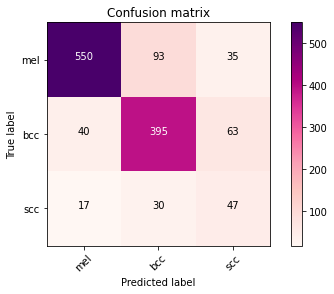

In [ ]:
plot_confusion_matrix(validate_mc(y_pred, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
with open(os.path.join(save_path, 'models', 'xt_a_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_a, f)
print("Model saved..\n")

Model saved..



##### Features B

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_B' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_B' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_b = np.hstack([val_variegation_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_b.shape)

train_ft: (5082, 630)
train_labels: (5082,)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_b = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_b.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xt_lg_b.predict(val_features_b)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 8648.563875675201
Scores XT classifier : {'confusion_matrix': array([[543,  89,  46],
       [ 43, 370,  85],
       [ 14,  29,  51]]), 'accuracy': 0.7590551181102362, 'kappa': 0.5891827207685671, 'bma': 0.6954700115972582}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_b_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_b, f)
print("Model saved..\n")

Model saved..



##### Features C

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_C' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_C' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_c = np.hstack([val_variegation_fd, val_color_feature_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_c.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_c = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_c.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xt_lg_c.predict(val_features_c)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 8776.014205932617
Scores XT classifier : {'confusion_matrix': array([[544,  94,  40],
       [ 44, 376,  78],
       [ 14,  33,  47]]), 'accuracy': 0.7614173228346457, 'kappa': 0.5900781899141402, 'bma': 0.6857933207757282}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_c_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_c, f)
print("Model saved..\n")

Model saved..



##### Features D

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_D' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_D' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_d = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_d.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_d = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_d.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xt_lg_d.predict(val_features_d)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 8945.61080622673
Scores XT classifier : {'confusion_matrix': array([[547,  94,  37],
       [ 46, 371,  81],
       [ 14,  30,  50]]), 'accuracy': 0.7622047244094489, 'kappa': 0.5915668141913335, 'bma': 0.6945598246875658}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_d_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_d, f)
print("Model saved..\n")

Model saved..



##### Features E


In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_E' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_E' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_e = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_e.shape)

train_ft: (5082, 450)
train_labels: (5082,)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_e = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_e.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xt_lg_e.predict(val_features_e)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 9145.92568063736
Scores XT classifier : {'confusion_matrix': array([[523,  96,  59],
       [ 45, 369,  84],
       [ 13,  28,  53]]), 'accuracy': 0.7440944881889764, 'kappa': 0.5678209590343481, 'bma': 0.6920600244447318}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_e_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_e, f)
print("Model saved..\n")

Model saved..



##### Features F

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_F' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_F' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_f = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_f.shape)

train_ft: (5082, 591)
train_labels: (5082,)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_f = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_f.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xt_lg_f.predict(val_features_f)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 9252.982637405396
Scores XT classifier : {'confusion_matrix': array([[534,  95,  49],
       [ 43, 372,  83],
       [ 17,  29,  48]]), 'accuracy': 0.7511811023622047, 'kappa': 0.575879269529929, 'bma': 0.6817456230495319}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_f_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_f, f)
print("Model saved..\n")

Model saved..



##### Features G

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_G' + '.pkl'), 'rb') as file:
    train_features_sm = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_G' + '.pkl'), 'rb') as file:
    train_labels_sm = pickle.load(file)

val_features_g = np.hstack([val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('train_ft:', train_features_sm.shape)
print('train_labels:', train_labels_sm.shape)
print('val_ft:', val_features_g.shape)

train_ft: (5082, 639)
train_labels: (5082,)
val_ft: (1270, 639)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
xt_lg_g = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_g.fit(train_features_sm, train_labels_sm)
# Evaluation
y_pred = xt_lg_g.predict(val_features_g)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 50.67425084114075
Scores XT classifier : {'confusion_matrix': array([[553,  90,  35],
       [ 39, 400,  59],
       [ 16,  30,  48]]), 'accuracy': 0.7881889763779527, 'kappa': 0.6320101511469589, 'bma': 0.7098284558556828}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_g_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_g, f)
print("Model saved..\n")

Model saved..



##### Sklearn Feature selection

1. SelectBest

In [ ]:
strt = time.time()
selector = SelectKBest()
xt = ExtraTreesClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 13)  # RF classifier
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("xt", xt)])
params = {'selector__k':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xt_kbest = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True)), ("selector", SelectKBest(k =  grid_search.best_params_["selector__k"])), ("xt", ExtraTreesClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 13))])
xt_kbest.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = xt_kbest.predict(val_features_all)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

2. PCA

In [ ]:
strt = time.time()
pca = PCA()
xt = ExtraTreesClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 13)  # RF classifier
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("xt", xt)])
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}  # Parameter to be used in the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  # CV Gridsearch with the BMA metric to evaluate the CV performances

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xt_pca = Pipeline(steps=[("pp",  PowerTransformer(method='yeo-johnson', standardize=True) ), ("pca", PCA(n_components =  grid_search.best_params_["pca__n_components"])), ("xt", ExtraTreesClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 13))])
xt_pca.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = xt_pca.predict(val_features_all)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Training best_score_ : 0.5974502923976608
Best Parameters {'pca__n_components': 13}
Total Time = 72.66940093040466
Scores XT classifier : {'confusion_matrix': array([[500,  87,  91],
       [ 45, 289, 164],
       [ 13,  24,  57]]), 'accuracy': 0.6661417322834645, 'kappa': 0.46475714876427365, 'bma': 0.6413891302358748}


3. Model-based selection

In [ ]:
strt = time.time()
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_m = SelectFromModel(lsvc, prefit=False)
xt = ExtraTreesClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 13)  # RF classifier

xt_m_select = Pipeline(steps=[("pp", transform), ("selector", selector_m), ("xt", xt)])
xt_m_select.fit(train_features_all, train_labels_all)

# Evaluation
y_pred = xt_m_select.predict(val_features_all)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 5.376686334609985
Scores XT classifier : {'confusion_matrix': array([[516,  81,  81],
       [ 40, 330, 128],
       [ 11,  30,  53]]), 'accuracy': 0.7078740157480315, 'kappa': 0.5212796222013598, 'bma': 0.662514112182112}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_best_smund_yeo' + '.pkl'), 'wb') as f:
        pickle.dump(xt_m_select, f)
print("Model saved..\n")

Model saved..



##### Features A with StandardScaler

In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'], criterion=grid_search.best_params_['xt__criterion'], max_depth=grid_search.best_params_['xt__max_depth'])  # XT classifier
scaler = StandardScaler()
xt_lg_a = Pipeline(steps=[("scaler", scaler), ("xt", xt)])
xt_lg_a.fit(train_features_all, train_labels_all)
# Evaluation
y_pred = xt_lg_a.predict(val_features_all)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 8289.870518445969
Scores XT classifier : {'confusion_matrix': array([[539,  92,  47],
       [ 47, 372,  79],
       [ 14,  29,  51]]), 'accuracy': 0.75748031496063, 'kappa': 0.5856127668049511, 'bma': 0.6948421313446845}


In [ ]:
with open(os.path.join(save_path, 'models', 'xt_a_smund' + '.pkl'), 'wb') as f:
        pickle.dump(xt_lg_a, f)
print("Model saved..\n")

Model saved..



##### Visually selected features

In [ ]:
# Get the sampled data
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Test Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_A_visualYeo' + '.pkl'), 'rb') as file:
    train_features_l = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_A_visualYeo' + '.pkl'), 'rb') as file:
    train_labels_l = pickle.load(file)

print('train_ft:', train_features_l.shape)
print('train_labels:', train_labels_l.shape)

train_ft: (5082, 552)
train_labels: (5082,)


In [ ]:
strt = time.time()
xt = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13)  # XT classifier
transform = PowerTransformer(method='yeo-johnson', standardize=True)
xt_lg_a = Pipeline(steps=[("pp", transform), ("xt", xt)])
xt_lg_a.fit(train_features_l, train_labels_l)
# Evaluation
y_pred = xt_lg_a.predict(val_features_l)  # Predictions
xt_scores = validate_mc(y_pred, val_labels)  # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores XT classifier :', xt_scores)

Total Time = 1347.8929255008698
Scores XT classifier : {'confusion_matrix': array([[551,  94,  33],
       [ 41, 399,  58],
       [ 16,  33,  45]]), 'accuracy': 0.7834645669291339, 'kappa': 0.6228173626050819, 'bma': 0.6975375297713794}


#### Ensemble


* *In this section, ensemble methods (Stacking and Majority voting from sklearn) will be tested on all features and with different classifiers.*

In [ ]:
train_csv_all = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv"
val_csv = "/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv"

In [ ]:
train_df = pd.read_csv(train_csv_all)
val_df = pd.read_csv(val_csv)

print(f'Train -->\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation -->\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train -->	 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


In [ ]:
# Open train features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# ---  Read Saved Train Features :  ---------------------------------
with open(os.path.join(save_path, 'features/features_train', 'train_variegation_fd' + '.pkl'), 'rb') as file:
    train_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_color_feature_fd' + '.pkl'), 'rb') as file:
    train_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_rgb_fd' + '.pkl'), 'rb') as file:
    train_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_hsv_fd' + '.pkl'), 'rb') as file:
    train_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_lab_fd' + '.pkl'), 'rb') as file:
    train_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_lbp_fd' + '.pkl'), 'rb') as file:
    train_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_haralick_fd' + '.pkl'), 'rb') as file:
    train_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_glcm_fd' + '.pkl'), 'rb') as file:
    train_glcm_fd = pickle.load(file)    

train_labels = np.array(train_df['label']).squeeze()
print(train_labels.shape)    

(5082,)


In [ ]:
# Open validation features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'features/features_val', 'val_variegation_fd' + '.pkl'), 'rb') as file:
    val_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_color_feature_fd' + '.pkl'), 'rb') as file:
    val_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_rgb_fd' + '.pkl'), 'rb') as file:
    val_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_hsv_fd' + '.pkl'), 'rb') as file:
    val_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_lab_fd' + '.pkl'), 'rb') as file:
    val_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_lbp_fd' + '.pkl'), 'rb') as file:
    val_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_haralick_fd' + '.pkl'), 'rb') as file:
    val_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_glcm_fd' + '.pkl'), 'rb') as file:
    val_glcm_fd = pickle.load(file)    

val_labels = np.array(val_df['label']).squeeze()
print(val_labels.shape)    

(1270,)


In [ ]:
# ---------------------  Feature vector 1 (2150, 72)  --------------------------
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_A' + '.pkl'), 'rb') as file:
    train_features_all = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_A' + '.pkl'), 'rb') as file:
    train_labels_all = pickle.load(file)

val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

print('Train features:', train_features_all.shape)
print('Train labels:', train_labels_all.shape)
print('Val features:', val_features_all.shape)
print('Val labels:', val_labels.shape)

Train features: (5082, 642)
Train labels: (5082,)
Val features: (1270, 642)
Val labels: (1270,)


In [ ]:
knnClf = KNeighborsClassifier(n_neighbors = 5)
xgbClf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=500, max_depth=7, learning_rate=0.1 )
svmClf = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)
rfClf = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 13) 
xtClf = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13) 

##### Stacking

In [ ]:
# ---  Using the Best Models as Base Models for the 2nd level Classifier (Meta_Clf) : 

# Training 
strt = time.time()

# classifiers = [('knn', knnClf), ('xgb', xgbClf), ('svm', svmClf), ('rf', rfClf), ('xt', xtClf)]  #all
# classifiers = [('svm', svmClf), ('xgb', xgbClf), ('rf', rfClf), ('xt', xtClf)]  # clf2
# classifiers = [('xgb', xgbClf), ('rf', rfClf), ('xt', xtClf)]  #clf3
# classifiers = [('knn', knnClf), ('xgb', xgbClf), ('rf', rfClf), ('xt', xtClf)]  # Clf4
# classifiers = [('knn', knnClf), ('svm', svmClf), ('rf', rfClf), ('xt', xtClf)]  # Clf5
# classifiers = [('svm', svmClf), ('xgb', xgbClf)]  # clf6

# classifiers = [('svm', svmClf), ('xgb', xgbClf), ('xt', xtClf)]  # clf_stacking1
classifiers = [('svm', svmClf), ('xgb', xgbClf), ('knn', knnClf)]  # clf_stacking2

stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=5)
transform = PowerTransformer(method='yeo-johnson', standardize=True)
stacking_pipe = Pipeline(steps=[('pp', transform), ('model', stacking_clf)])

stacking_pipe.fit(train_features_all, train_labels_all)
y_pred = stacking_pipe.predict(val_features_all)  # Predictions
end = time.time()
print('Time :', (end-strt))
print("Accuracy for Stacked classifiers :", validate_mc(y_pred, val_labels))

Accuracy for Stacked classifiers : {'confusion_matrix': array([[592,  77,   9],
       [ 40, 440,  18],
       [ 18,  36,  40]]), 'accuracy': 0.8440944881889764, 'kappa': 0.7176218517969519, 'bma': 0.7274074645408976}


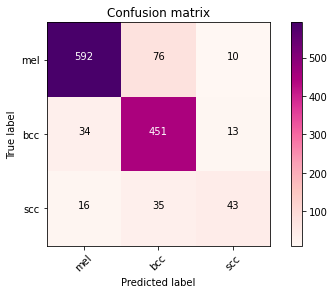

In [ ]:
plot_confusion_matrix(validate_mc(y_pred, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
# ---  Save the Fitted models in the Save_Folder :  ----------------------------

if save_path is not None:
  # # -- Stacking Classifier :  --------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'models'), exist_ok=True)
  with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_stk2' + '.pkl'), 'wb') as f:
          pickle.dump(stacking_pipe, f)
  print("Stacked model was saved..\n")

Stacked model was saved..



##### Majority Voting

In [ ]:
# ---  Using the Best Models for Majority Voting (soft) : 

strt = time.time()
# classifiers = [('knn', knnClf), ('xgb', xgbClf), ('svm', svmClf), ('rf', rfClf), ('xt', xtClf)]  #all
# classifiers = [('svm', svmClf), ('xgb', xgbClf), ('rf', rfClf), ('xt', xtClf)]  # clf2
# classifiers = [('xgb', xgbClf), ('rf', rfClf), ('xt', xtClf)]  #clf3
# classifiers = [('knn', knnClf), ('xgb', xgbClf), ('rf', rfClf), ('xt', xtClf)]  # Clf4
# classifiers = [('knn', knnClf), ('svm', svmClf), ('rf', rfClf), ('xt', xtClf)]  # Clf5
classifiers = [('svm', svmClf), ('xgb', xgbClf)]  # clf6
# classifiers = [('svm', svmClf), ('rf', rfClf)]  # clf7
# classifiers = [('svm', svmClf), ('xt', xtClf)]  # clf8
# classifiers = [('xgb', xgbClf), ('rf', rfClf)]  # clf9
# classifiers = [('xgb', xgbClf), ('xt', xtClf)]  # clf10
# classifiers = [('svm', svmClf), ('xgb', xgbClf), ('rf', rfClf)]  # clf11
# classifiers = [('svm', svmClf), ('xgb', xgbClf), ('xt', xtClf)]  # clf12

# classifiers = [('svm', svmClf), ('xgb', xgbClf), ('knn', knnClf)]  # voting2

eclf = VotingClassifier(estimators=classifiers, voting='soft')
transform = PowerTransformer(method='yeo-johnson', standardize=True)
voting_pipe = Pipeline(steps=[('pp', transform), ('model', eclf)])

voting_pipe.fit(train_features_all, train_labels_all)
y_pred = voting_pipe.predict(val_features_all)  # Predictions
end = time.time()
print('Time :', (end-strt))
print("Accuracy for Stacked classifiers :", validate_mc(y_pred, val_labels))
print('F1-score:', f1_score(val_labels, y_pred, average=None))

Time : 497.1405739784241
Accuracy for Stacked classifiers : {'confusion_matrix': array([[591,  74,  13],
       [ 35, 445,  18],
       [ 22,  30,  42]]), 'accuracy': 0.8488188976377953, 'kappa': 0.7270321462634839, 'bma': 0.7373547412520854}
F1-score: [0.89140271 0.85004776 0.50299401]


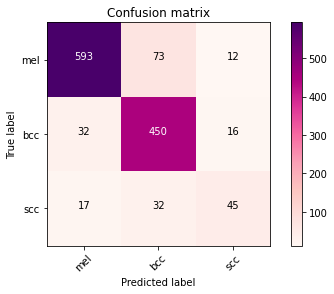

In [ ]:
plot_confusion_matrix(validate_mc(y_pred, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

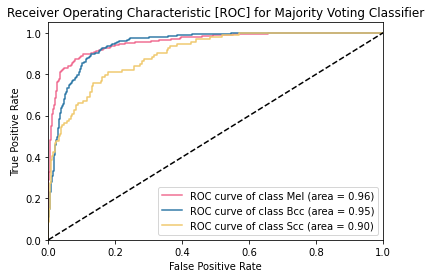

{0: 0.9562031611257276, 1: 0.9462149114593087, 2: 0.8978053987552468}

In [ ]:
# Plotting the ROC Curve :
y_proba_6 = cvlf.predict_proba(val_features_all)
plot_roc(val_labels, y_proba_6, True, 'Majority Voting')

In [ ]:
# ---  Save the Fitted models in the Save_Folder :  ----------------------------

import pickle
if save_path is not None:
  # # -- Stacking Classifier :  --------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'models'), exist_ok=True)
  with open(os.path.join(save_path, 'models', 'voting_clf_yeo_6' + '.pkl'), 'wb') as f:
          pickle.dump(eclf, f)
  print("Stacked model was saved..\n")

Stacked model was saved..



#### Ensemble with pretrained models (soft)

*In this section, we ensemble the best models that we trained in the previous sections to create averaging ensembles*

In [ ]:
with open(os.path.join(save_path, 'models', 'knn_a_smund_yeo' + '.pkl'), 'rb') as file:
    knnClf = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xgb_a_smund_yeo' + '.pkl'), 'rb') as file:
    xgbClf = pickle.load(file)   
with open(os.path.join(save_path, 'models', 'svm_a_smund_yeo' + '.pkl'), 'rb') as file:
    svmClf = pickle.load(file)
with open(os.path.join(save_path, 'models', 'rf_a_smund_yeo' + '.pkl'), 'rb') as file:
    rfClf = pickle.load(file)
with open(os.path.join(save_path, 'models', 'xt_a_smund_yeo' + '.pkl'), 'rb') as file:
    xtClf = pickle.load(file)    

In [ ]:
xgbt_probs = xgbClf.predict_proba(val_features_all) 
svm_probs = svmClf.predict_proba(val_features_all) 
xtree_probs = xtClf.predict_proba(val_features_all) 
rf_probs = rfClf.predict_proba(val_features_all) 
knn_probs = knnClf.predict_proba(val_features_all)

In [ ]:
y_probs_1 = ( svm_probs + xgbt_probs + xtree_probs + knn_probs + rf_probs)/5
y_preds_1 = np.argmax(y_probs_1, axis=1)
scores = validate_mc(y_preds_1, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_1, average=None))

{'confusion_matrix': array([[583,  76,  19],
       [ 33, 431,  34],
       [ 17,  28,  49]]), 'accuracy': 0.837007874015748, 'kappa': 0.7103804307111978, 'bma': 0.7488734830113147}
[0.88939741 0.83446273 0.5       ]


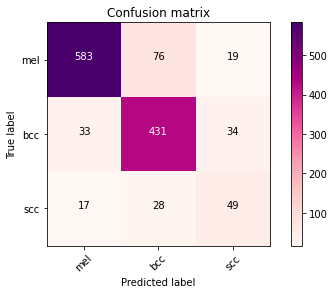

In [ ]:
plot_confusion_matrix(validate_mc(y_preds_1, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
y_probs_2 = (svm_probs + xgbt_probs + knn_probs + rf_probs)/4
y_preds_2 = np.argmax(y_probs_2, axis=1)
scores = validate_mc(y_preds_2, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_2, average=None))

y_probs_2 = (svm_probs + xgbt_probs + xtree_probs + knn_probs)/4
y_preds_2 = np.argmax(y_probs_2, axis=1)
scores = validate_mc(y_preds_2, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_2, average=None))

y_probs_2 = (svm_probs + xgbt_probs + xtree_probs + rf_probs)/4
y_preds_2 = np.argmax(y_probs_2, axis=1)
scores = validate_mc(y_preds_2, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_2, average=None))

{'confusion_matrix': array([[584,  74,  20],
       [ 34, 432,  32],
       [ 17,  27,  50]]), 'accuracy': 0.8393700787401575, 'kappa': 0.7144645714764346, 'bma': 0.7535805684294953}
[0.88956588 0.83802134 0.51020408]
{'confusion_matrix': array([[580,  77,  21],
       [ 32, 432,  34],
       [ 18,  25,  51]]), 'accuracy': 0.837007874015748, 'kappa': 0.7110667088707763, 'bma': 0.7551600993820257}
[0.88685015 0.8372093  0.51      ]
{'confusion_matrix': array([[584,  76,  18],
       [ 32, 447,  19],
       [ 21,  31,  42]]), 'accuracy': 0.8448818897637795, 'kappa': 0.7212976330517236, 'bma': 0.7352519347458245}
[0.88821293 0.84980989 0.48554913]


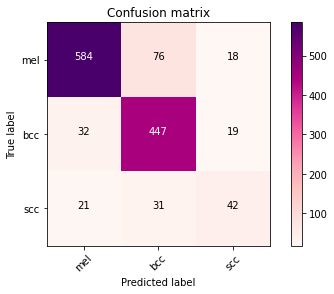

In [ ]:
plot_confusion_matrix(validate_mc(y_preds_2, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
y_probs_3 =  (svm_probs + xgbt_probs + knn_probs)/3
y_preds_3 = np.argmax(y_probs_3, axis=1)
scores = validate_mc(y_preds_3, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_3, average=None))

y_probs_3 =  (svm_probs + xgbt_probs + xtree_probs)/3
y_preds_3 = np.argmax(y_probs_3, axis=1)
scores = validate_mc(y_preds_3, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_3, average=None))

{'confusion_matrix': array([[583,  73,  22],
       [ 34, 433,  31],
       [ 17,  25,  52]]), 'accuracy': 0.8409448818897638, 'kappa': 0.7176970310539869, 'bma': 0.7608504689693313}
[0.88871951 0.84159378 0.52261307]
{'confusion_matrix': array([[590,  75,  13],
       [ 32, 448,  18],
       [ 20,  31,  43]]), 'accuracy': 0.8511811023622047, 'kappa': 0.7317429166629413, 'bma': 0.7424172305868173}
[0.89393939 0.85171103 0.51190476]


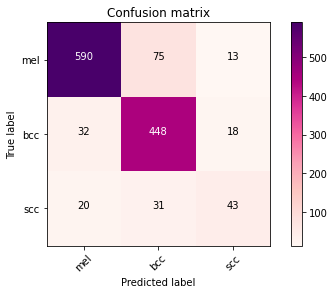

In [ ]:
plot_confusion_matrix(validate_mc(y_preds_3, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

In [ ]:
y_probs_4 = (svm_probs + xtree_probs)/2
y_preds_4 = np.argmax(y_probs_4, axis=1)
scores = validate_mc(y_preds_4, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_4, average=None))

y_probs_4 = (svm_probs + knn_probs)/2
y_preds_4 = np.argmax(y_probs_4, axis=1)
scores = validate_mc(y_preds_4, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_4, average=None))

y_probs_4 = (svm_probs + xgbt_probs)/2
y_preds_4 = np.argmax(y_probs_4, axis=1)
scores = validate_mc(y_preds_4, val_labels)
print(scores)
print(f1_score(val_labels, y_preds_4, average=None))

{'confusion_matrix': array([[594,  75,   9],
       [ 38, 439,  21],
       [ 19,  35,  40]]), 'accuracy': 0.8448818897637795, 'kappa': 0.7193732193732194, 'bma': 0.7277214046671845}
[0.89390519 0.83858644 0.48780488]
{'confusion_matrix': array([[571,  77,  30],
       [ 29, 418,  51],
       [ 13,  20,  61]]), 'accuracy': 0.8267716535433071, 'kappa': 0.6987497142758564, 'bma': 0.776825496929033}
[0.88458559 0.82527147 0.51694915]
{'confusion_matrix': array([[591,  74,  13],
       [ 35, 445,  18],
       [ 22,  30,  42]]), 'accuracy': 0.8488188976377953, 'kappa': 0.7270321462634839, 'bma': 0.7373547412520854}
[0.89140271 0.85004776 0.50299401]


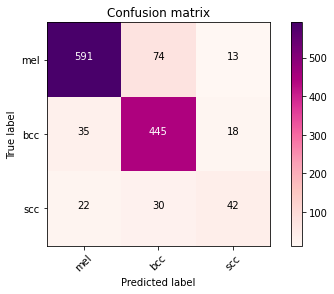

In [ ]:
plot_confusion_matrix(validate_mc(y_preds_4, val_labels)['confusion_matrix'], ['mel', 'bcc', 'scc'], cmap='RdPu')

#### Results summary

##### Stacking

In [ ]:
with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_all' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
stacked_scores_1 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_2' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
stacked_scores_2 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_3' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
stacked_scores_3 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_4' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
stacked_scores_4 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_5' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
stacked_scores_5 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'stacking_clf_yeo_6' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
stacked_scores_6 = validate_mc(y_pred, val_labels)

In [ ]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results using Stacking :')
table = [['KNN', 'SVM', 'XGB', 'RF', 'XTrees', 'Acc', 'BMA', 'Kappa', 'Confusion_Matrix'], 
         ['X', 'X', 'X', 'X', 'X', stacked_scores_1['accuracy'], stacked_scores_1['bma'], stacked_scores_1['kappa'], stacked_scores_1['confusion_matrix'] ],
         [' ', 'X', 'X', 'X', 'X', stacked_scores_2['accuracy'], stacked_scores_2['bma'], stacked_scores_2['kappa'], stacked_scores_2['confusion_matrix'] ],
         [' ', ' ', 'X', 'X', 'X', stacked_scores_3['accuracy'], stacked_scores_3['bma'], stacked_scores_3['kappa'], stacked_scores_3['confusion_matrix'] ],
         ['X', ' ', 'X', 'X', 'X', stacked_scores_4['accuracy'], stacked_scores_4['bma'], stacked_scores_4['kappa'], stacked_scores_4['confusion_matrix'] ],
         ['X', 'X', ' ', 'X', 'X', stacked_scores_5['accuracy'], stacked_scores_5['bma'], stacked_scores_5['kappa'], stacked_scores_5['confusion_matrix'] ],
         [' ', 'X', 'X', ' ', ' ', stacked_scores_6['accuracy'], stacked_scores_6['bma'], stacked_scores_6['kappa'], stacked_scores_6['confusion_matrix'] ]
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results using Stacking :
╒═══════╤═══════╤═══════╤══════╤══════════╤══════════╤══════════╤══════════╤════════════════════╕
│ KNN   │ SVM   │ XGB   │ RF   │ XTrees   │   Acc    │   BMA    │  Kappa   │ Confusion_Matrix   │
╞═══════╪═══════╪═══════╪══════╪══════════╪══════════╪══════════╪══════════╪════════════════════╡
│ X     │ X     │ X     │ X    │ X        │ 0.853543 │ 0.741193 │ 0.73499  │ [[592  77   9]     │
│       │       │       │      │          │          │          │          │  [ 33 450  15]     │
│       │       │       │      │          │          │          │          │  [ 18  34  42]]    │
├───────┼───────┼───────┼──────┼──────────┼──────────┼──────────┼──────────┼────────────────────┤
│       │ X     │ X     │ X    │ X        │ 0.851181 │ 0.727856 │ 0.729859 │ [[591  79   8]     │
│       │       │       │      │          │          │          │          │  [ 33 452  13]     │
│       │       │       │      │          │          │          │          │  

##### Majority voting

In [ ]:
with open(os.path.join(save_path, 'models', 'voting_clf_yeo_all' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_1 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_2' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_2 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_3' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_3 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_4' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_4 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_5' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_5 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_6' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred_6 = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_6 = validate_mc(y_pred_6, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_7' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_7 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_8' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_8 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_9' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_9 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_10' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_10 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_11' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_11 = validate_mc(y_pred, val_labels)

with open(os.path.join(save_path, 'models', 'voting_clf_yeo_voting1' + '.pkl'), 'rb') as file:
    model_tofit = pickle.load(file)
y_pred = model_tofit.predict(val_features_all)  # Predictions
majvote_scores_12 = validate_mc(y_pred, val_labels)

In [ ]:
# ---  Show Prediction Scores for each Classifier :  -----------------------------

print('Classification Results using Majority Voting :')
table = [['KNN', 'SVM', 'XGB', 'RF', 'XTrees', 'Acc', 'BMA', 'Kappa', 'Confusion_Matrix'], 
         ['X', 'X', 'X', 'X', 'X', majvote_scores_1['accuracy'], majvote_scores_1['bma'], majvote_scores_1['kappa'], majvote_scores_1['confusion_matrix'] ],
         [' ', 'X', 'X', 'X', 'X', majvote_scores_2['accuracy'], majvote_scores_2['bma'], majvote_scores_2['kappa'], majvote_scores_2['confusion_matrix'] ],
         [' ', ' ', 'X', 'X', 'X', majvote_scores_3['accuracy'], majvote_scores_3['bma'], majvote_scores_3['kappa'], majvote_scores_3['confusion_matrix'] ],
         ['X', ' ', 'X', 'X', 'X', majvote_scores_4['accuracy'], majvote_scores_4['bma'], majvote_scores_4['kappa'], majvote_scores_4['confusion_matrix'] ],
         ['X', 'X', ' ', 'X', 'X', majvote_scores_5['accuracy'], majvote_scores_5['bma'], majvote_scores_5['kappa'], majvote_scores_5['confusion_matrix'] ],
         [' ', 'X', 'X', ' ', ' ', majvote_scores_6['accuracy'], majvote_scores_6['bma'], majvote_scores_6['kappa'], majvote_scores_6['confusion_matrix'] ],
         [' ', 'X', ' ', 'X', ' ', majvote_scores_7['accuracy'], majvote_scores_7['bma'], majvote_scores_7['kappa'], majvote_scores_7['confusion_matrix'] ],
         [' ', 'X', ' ', ' ', 'X', majvote_scores_8['accuracy'], majvote_scores_8['bma'], majvote_scores_8['kappa'], majvote_scores_8['confusion_matrix'] ],
         [' ', ' ', 'X', 'X', ' ', majvote_scores_9['accuracy'], majvote_scores_9['bma'], majvote_scores_9['kappa'], majvote_scores_9['confusion_matrix'] ],
         [' ', ' ', 'X', ' ', 'X', majvote_scores_10['accuracy'], majvote_scores_10['bma'], majvote_scores_10['kappa'], majvote_scores_10['confusion_matrix'] ],
         [' ', 'X', 'X', 'X', ' ', majvote_scores_11['accuracy'], majvote_scores_11['bma'], majvote_scores_11['kappa'], majvote_scores_11['confusion_matrix'] ],
         [' ', 'X', 'X', ' ', 'X', majvote_scores_12['accuracy'], majvote_scores_12['bma'], majvote_scores_12['kappa'], majvote_scores_12['confusion_matrix'] ]
         ]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign='center'))

Classification Results using Majority Voting :
╒═══════╤═══════╤═══════╤══════╤══════════╤══════════╤══════════╤══════════╤════════════════════╕
│ KNN   │ SVM   │ XGB   │ RF   │ XTrees   │   Acc    │   BMA    │  Kappa   │ Confusion_Matrix   │
╞═══════╪═══════╪═══════╪══════╪══════════╪══════════╪══════════╪══════════╪════════════════════╡
│ X     │ X     │ X     │ X    │ X        │ 0.845669 │ 0.765577 │ 0.725501 │ [[579  84  15]     │
│       │       │       │      │          │          │          │          │  [ 28 443  27]     │
│       │       │       │      │          │          │          │          │  [ 13  29  52]]    │
├───────┼───────┼───────┼──────┼──────────┼──────────┼──────────┼──────────┼────────────────────┤
│       │ X     │ X     │ X    │ X        │ 0.850394 │ 0.741748 │ 0.730365 │ [[590  78  10]     │
│       │       │       │      │          │          │          │          │  [ 31 447  20]     │
│       │       │       │      │          │          │          │      

##### Classification results (qualitative)

In [ ]:
val_df['pred'] = y_pred_6

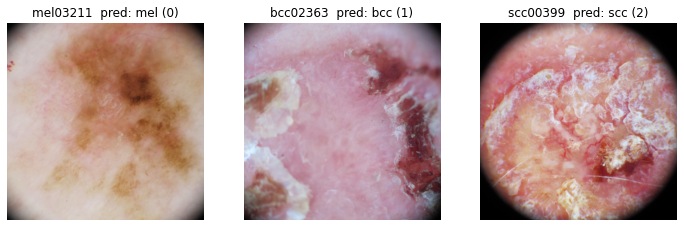

In [ ]:
# Show classification results on Validation set :
val_samples = val_df.sample(50)

# Correctly classified images :
fig, axes = plt.subplots(nrows=1, ncols = 3, figsize=(12, 5))
ax = 0
lab=['mel', 'bcc', 'scc']

for i, row in val_samples.iterrows():
  if(row['label']==ax & row['pred']==ax):
    img_id = row["image_id"]
    img = read_img(img_id, "val")
    axes[ax].imshow(img)
    k = int(row['pred'])
    axes[ax].set_title(f'{img_id}  pred: {lab[k]} ({k})')
    axes[ax].axis('off')
    ax +=1 

plt.subplots_adjust()
plt.show()

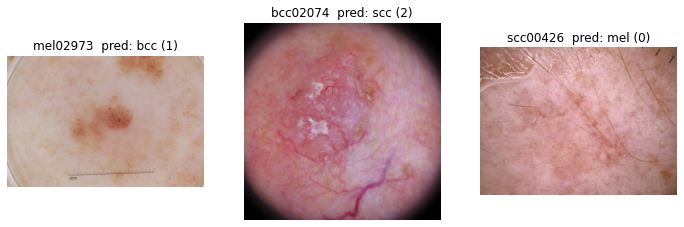

In [ ]:
# Show classification results on Validation set :

# Wrongly classified images :
fig, axes = plt.subplots(nrows=1, ncols = 3, figsize=(12, 5))
ax = 0
lab=['mel', 'bcc', 'scc']

for i, row in val_samples.iterrows():
  if((row['label']==ax and row['pred']!=ax)==True):
      img_id = row["image_id"]
      img = read_img(img_id, "val")
      axes[ax].imshow(img)
      k = int(row['pred'])
      axes[ax].set_title(f'{img_id}  pred: {lab[k]} ({k})')
      axes[ax].axis('off')
      ax +=1 

plt.subplots_adjust()
plt.show()

In [ ]:
results_df = pd.read_csv('/content/kappa_results.csv')

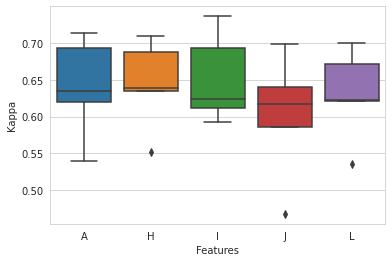

In [ ]:
sns.set_style("whitegrid") 
sns.boxplot(x = results_df['Features'], y = results_df['Kappa'].astype(np.float64))

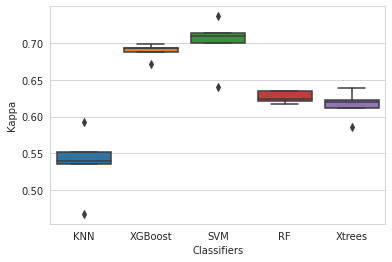

In [ ]:
sns.set_style("whitegrid") 
sns.boxplot(x = results_df['Classifiers'], y = results_df['Kappa'].astype(np.float64))

### Retraining Best Model with all data

*After finding the best model for this multiclass classification task, the model will be retrained using all the dataset (Train + Validation)*

In [ ]:
train_csv_all = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv"
val_csv = "/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv"

In [ ]:
train_df = pd.read_csv(train_csv_all)
val_df = pd.read_csv(val_csv)

print(f'Train -->\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation -->\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train -->	 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


In [ ]:
# Open train features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# ---  Read Saved Train Features :  ---------------------------------
with open(os.path.join(save_path, 'features/features_train', 'train_variegation_fd' + '.pkl'), 'rb') as file:
    train_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_color_feature_fd' + '.pkl'), 'rb') as file:
    train_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_rgb_fd' + '.pkl'), 'rb') as file:
    train_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_hsv_fd' + '.pkl'), 'rb') as file:
    train_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_lab_fd' + '.pkl'), 'rb') as file:
    train_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_lbp_fd' + '.pkl'), 'rb') as file:
    train_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_haralick_fd' + '.pkl'), 'rb') as file:
    train_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_train', 'train_glcm_fd' + '.pkl'), 'rb') as file:
    train_glcm_fd = pickle.load(file)    

train_labels = np.array(train_df['label']).squeeze()
print(train_labels.shape)    

(5082,)


In [ ]:
# Open validation features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'features/features_val', 'val_variegation_fd' + '.pkl'), 'rb') as file:
    val_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_color_feature_fd' + '.pkl'), 'rb') as file:
    val_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_rgb_fd' + '.pkl'), 'rb') as file:
    val_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_hsv_fd' + '.pkl'), 'rb') as file:
    val_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_lab_fd' + '.pkl'), 'rb') as file:
    val_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_lbp_fd' + '.pkl'), 'rb') as file:
    val_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_haralick_fd' + '.pkl'), 'rb') as file:
    val_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features/features_val', 'val_glcm_fd' + '.pkl'), 'rb') as file:
    val_glcm_fd = pickle.load(file)    

val_labels = np.array(val_df['label']).squeeze()
print(val_labels.shape)    

(1270,)


* *Stacking data*

In [ ]:
# stacking all the data together (Train + Val) :

train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
val_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])

all_data = np.vstack((train_features_all, val_features_all))
all_labels = np.append(train_labels, val_labels)
print(all_data.shape)
print(all_labels.shape)

(6352, 642)
(6352,)


In [ ]:
print('Total number of label 0:', np.count_nonzero(all_labels==0))
print('Total number of label 1:', np.count_nonzero(all_labels==1))
print('Total number of label 2:', np.count_nonzero(all_labels==2))

0: 3391
1: 2491
2: 470


* *Sampling*

In [ ]:
# OverUnderSampling using SMOTE approach :
sm = SMOTE(sampling_strategy={0: 3391, 1: 2491, 2: 1700}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 1700, 1: 1700, 2: 1700})
steps = [('o', sm), ('u', under)]
pipeline = pipel(steps=steps)
train_features_res, train_labels_res = pipeline.fit_resample(all_data, all_labels)

print('Original dataset shape:', Counter(all_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

# Save Shuffled Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_all1700' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_all1700' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

Original dataset shape: Counter({0: 3391, 1: 2491, 2: 470})
Resampled dataset shape: Counter({0: 1700, 1: 1700, 2: 1700})
train_features_res were saved..

train_labels_res were saved..



* *Define data and models*

In [ ]:
# -- Read Saved Train Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_features_all1700' + '.pkl'), 'rb') as file:
    train_features_all_1700 = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'sm_und_train_labels_all1700' + '.pkl'), 'rb') as file:
    train_labels_all_1700 = pickle.load(file)

# Define Classifiers :
xgbClf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=500, max_depth=7, learning_rate=0.1 )
svmClf = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)

In [ ]:
# Training the model :
strt = time.time()

classifiers = [('svm', svmClf), ('xgb', xgbClf)]  # clf6
eclf = VotingClassifier(estimators=classifiers, voting='soft')
transform = PowerTransformer(method='yeo-johnson', standardize=True)
voting_pipe = Pipeline(steps=[('pp', transform), ('model', eclf)])

voting_pipe.fit(train_features_all_1700, train_labels_all_1700)
end = time.time()
print('Time :', (end-strt))

Time : 509.5832495689392


In [ ]:
# ---  Save the Fitted models in the Save_Folder :  ----------------------------

import pickle
if save_path is not None:
  # # -- Stacking Classifier :  --------------------------------------------------------
  # os.makedirs(os.path.join(save_path, 'models'), exist_ok=True)
  with open(os.path.join(save_path, 'models', 'voting_smund1700_yeo_newAll_clf6' + '.pkl'), 'wb') as f:
          # pickle.dump(voting_pipe, f)
  print("Stacked model was saved..\n")


Stacked model was saved..



### Hierarchical Architecture

In [ ]:
train_csv_all = "/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv"
val_csv = "/content/drive/MyDrive/CAD_Dataset/Chapllenge2/val.csv"

In [ ]:
train_df = pd.read_csv(train_csv_all)
val_df = pd.read_csv(val_csv)

print(f'Train -->\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation -->\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train -->	 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


##### Train - All sampls

In [ ]:
# Open train features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2/features'

# ---  Read Saved Train Features :  ---------------------------------
with open(os.path.join(save_path, 'features_train', 'train_variegation_fd' + '.pkl'), 'rb') as file:
    train_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_color_feature_fd' + '.pkl'), 'rb') as file:
    train_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_rgb_fd' + '.pkl'), 'rb') as file:
    train_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_hsv_fd' + '.pkl'), 'rb') as file:
    train_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_lab_fd' + '.pkl'), 'rb') as file:
    train_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_lbp_fd' + '.pkl'), 'rb') as file:
    train_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_haralick_fd' + '.pkl'), 'rb') as file:
    train_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_train', 'train_glcm_fd' + '.pkl'), 'rb') as file:
    train_glcm_fd = pickle.load(file)    

train_labels = np.array(train_df['label']).squeeze()
   
print('train_variegation_fd shape:', train_variegation_fd.shape)
print('train_color_feature_fd shape:', train_color_feature_fd.shape)
print('train_rgb_fd shape:', train_rgb_fd.shape)
print('train_hsv_fd shape:', train_hsv_fd.shape)
print('train_lab_fd shape:', train_lab_fd.shape)
print('train_lbp_fd shape:', train_lbp_fd.shape)
print('train_haralick_fd shape:', train_haralick_fd.shape)
print('train_glcm_fd shape:', train_glcm_fd.shape)
print('train_labels shape:', train_labels.shape)

(5082,)


##### Validation

In [ ]:
# Open validation features 
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2/features'

# ---  Read Saved Train+Validation Features :  ---------------------------------
with open(os.path.join(save_path, 'features_val', 'val_variegation_fd' + '.pkl'), 'rb') as file:
    val_variegation_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_color_feature_fd' + '.pkl'), 'rb') as file:
    val_color_feature_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_rgb_fd' + '.pkl'), 'rb') as file:
    val_rgb_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_hsv_fd' + '.pkl'), 'rb') as file:
    val_hsv_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_lab_fd' + '.pkl'), 'rb') as file:
    val_lab_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_lbp_fd' + '.pkl'), 'rb') as file:
    val_lbp_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_haralick_fd' + '.pkl'), 'rb') as file:
    val_haralick_fd = pickle.load(file)

with open(os.path.join(save_path, 'features_val', 'val_glcm_fd' + '.pkl'), 'rb') as file:
    val_glcm_fd = pickle.load(file)    

test_labels = np.array(val_df['label']).squeeze()

print('val_variegation_fd shape:', val_variegation_fd.shape)
print('val_color_feature_fd shape:', val_color_feature_fd.shape)
print('val_rgb_fd shape:', val_rgb_fd.shape)
print('val_hsv_fd shape:', val_hsv_fd.shape)
print('val_lab_fd shape:', val_lab_fd.shape)
print('val_lbp_fd shape:', val_lbp_fd.shape)
print('val_haralick_fd shape:', val_haralick_fd.shape)
print('val_glcm_fd shape:', val_glcm_fd.shape)
print('val_labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)    

(1270,)


In [ ]:
train_features_all = np.hstack([train_variegation_fd, train_color_feature_fd, train_rgb_fd, train_hsv_fd, train_lab_fd, train_lbp_fd, train_haralick_fd, train_glcm_fd]) 
test_features_all = np.hstack([val_variegation_fd, val_color_feature_fd, val_rgb_fd, val_hsv_fd, val_lab_fd, val_lbp_fd, val_haralick_fd, val_glcm_fd])
print('Train features shape:', train_features_all.shape)
print('Test features shape:', test_features_all.shape)

#### Data Splitting

In [ ]:
# Before Splitting the dataset :
print(f'Train -->\t Total: {len(train_df)}\t Melanoma: {len(train_df[train_df["label"]==0])}\t BCC: {len(train_df[train_df["label"]==1])}\t SCC: {len(train_df[train_df["label"]==2])}')
print(f'Validation -->\t Total: {len(val_df)}\t Melanoma: {len(val_df[val_df["label"]==0])}\t BCC: {len(val_df[val_df["label"]==1])}\t SCC: {len(val_df[val_df["label"]==2])}')

Train -->	 Total: 5082	 Melanoma: 2713	 BCC: 1993	 SCC: 376
Validation -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


In [ ]:
# Splitting the Train dataset into Train and Validation :
train_features, val_features, train_labels, val_labels = train_test_split(train_features_all, 
                                                                          train_labels, test_size=0.2, 
                                                                          random_state=42)

In [ ]:
# After Splitting the dataset :
print(f'Train -->\t Total: {len(train_features)}\t Melanoma: {np.count_nonzero(train_labels == 0)}\t BCC: {np.count_nonzero(train_labels == 1)}\t SCC: {np.count_nonzero(train_labels == 2)}')
print(f'Validation -->\t Total: {len(val_features)}\t Melanoma: {np.count_nonzero(val_labels == 0)}\t BCC: {np.count_nonzero(val_labels == 1)}\t SCC: {np.count_nonzero(val_labels == 2)}')
print(f'Test -->\t Total: {len(test_features_all)}\t Melanoma: {np.count_nonzero(test_labels == 0)}\t BCC: {np.count_nonzero(test_labels == 1)}\t SCC: {np.count_nonzero(test_labels == 2)}')

Train -->	 Total: 4065	 Melanoma: 2168	 BCC: 1608	 SCC: 289
Validation -->	 Total: 1017	 Melanoma: 545	 BCC: 385	 SCC: 87
Test -->	 Total: 1270	 Melanoma: 678	 BCC: 498	 SCC: 94


#### Sampling

*In this hierarchical approach, the sampling will be done such to have two main branches of 50% each, which means that mel=50%, bcc = 25% and scc=25%*

In [ ]:
# OverUnderSampling using SMOTE approach :

sm = SMOTE(sampling_strategy={0: 2168, 1: 1608, 2: 1016}, random_state=24)
under = RandomUnderSampler(sampling_strategy={0: 2032, 1: 1016, 2: 1016})
steps = [('o', sm), ('u', under)]
pipeline = imb_pipeline(steps=steps)

### Resample X_train_scaled
train_features_res, train_labels_res = pipeline.fit_resample(train_features, train_labels)

print('Original dataset shape:', Counter(train_labels))
print('Resampled dataset shape:', Counter(train_labels_res))

Original dataset shape: Counter({0: 2168, 1: 1608, 2: 289})
Resampled dataset shape: Counter({0: 2032, 1: 1016, 2: 1016})


In [ ]:
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2/'

# # Save Shuffled Features :
if save_path is not None:   
  with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_hiclass' + '.pkl'), 'wb') as f:
          # pickle.dump(train_features_res, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_hiclass' + '.pkl'), 'wb') as f:
          # pickle.dump(train_labels_res, f)
  print("train_labels_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'val_features_hiclass' + '.pkl'), 'wb') as f:
          # pickle.dump(val_features, f)
  print("train_features_res were saved..\n")

  with open(os.path.join(save_path, 'features/sampling', 'val_labels_hiclass' + '.pkl'), 'wb') as f:
          # pickle.dump(val_labels, f)
  print("train_labels_res were saved..\n")

train_features_res were saved..

train_labels_res were saved..

train_features_res were saved..

train_labels_res were saved..



#### Train

In [ ]:
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# -- Read Saved Train & Val Features : -----------------------------------------------------
with open(os.path.join(save_path, 'features/sampling', 'smund_train_features_hiclass' + '.pkl'), 'rb') as file:
    train_features = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'smund_train_labels_hiclass' + '.pkl'), 'rb') as file:
    train_labels = pickle.load(file)

with open(os.path.join(save_path, 'features/sampling', 'val_features_hiclass' + '.pkl'), 'rb') as file:
    val_features = pickle.load(file)
with open(os.path.join(save_path, 'features/sampling', 'val_labels_hiclass' + '.pkl'), 'rb') as file:
    val_labels = pickle.load(file)    

In [ ]:
# Converting the train labels into a hierarchical way
train_labels_h = []
for i in range(len(train_labels)):
  if train_labels[i] == 0:
    train_labels_h.append(['mel', '0'])
  elif train_labels[i] == 1:
    train_labels_h.append(['others', '1'])  # bcc
  elif train_labels[i] == 2:
    train_labels_h.append(['others', '2'])  # scc

In [ ]:
print('train_ft:', train_features.shape)
print('val_ft:', val_features.shape)
print('val_labels:', val_labels.shape)
print('test_ft:', test_features_all.shape)
print('test_labels:', test_labels.shape)

train_ft: (4064, 642)
val_ft: (1017, 642)
val_labels: (1017,)
test_ft: (1270, 642)
test_labels: (1270,)


In [ ]:
# ---  Feature Preprocessing :  --------------------------------------
clf = Pipeline([
    ('pp', PowerTransformer(method='yeo-johnson', standardize=True)),
  ])
model = clf.fit(train_features, train_labels_h)
train_features_sm = model.transform(train_features)
val_features_sm = model.transform(val_features)
test_features = model.transform(test_features_all)
train_labels_h = np.array(train_labels_h)
print('train_features Shape :', train_features_sm.shape)
print('val_features Shape :', val_features_sm.shape)
print('test_features Shape :', test_features.shape)

train_features Shape : (4064, 642)
val_features Shape : (1017, 642)
test_features Shape : (1270, 642)


##### *XGBoost*

In [ ]:
#  -----------------------------  XGBoost :  ---------------------------------
start = time.time()

xgbList1 = [100, 500, 1000, 2000]
xgbList2 = [3, 5, 7, 9, 13, 15, 17, 19, 21, 23]
xgbBMA = []
for i in xgbList1:
  for j in xgbList2:
    # Define the Classifiers
    xgb_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=i, max_depth=j, learning_rate=0.1, scale_pos_weight=1, random_state=23)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = xgb_clf)
    # Train local classifier
    classifier.fit(train_features_sm, train_labels_h)
    # Predict
    predictions = classifier.predict(val_features_sm)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i,'max_depth:', j, ', lr:0.1, is', validate_mc(y, val_labels))
    p = validate_mc(y, val_labels)
    xgbBMA.append([p['bma'], i, j]) 

end = time.time()
print('Total Time =', (end-start))
print('Results for XGB', np.vstack((xgbBMA)))

Scores for n_estimators: 100 max_depth: 3 , lr:0.1, is {'confusion_matrix': array([[463,  59,  23],
       [ 57, 270,  58],
       [ 20,  37,  30]]), 'accuracy': 0.7502458210422812, 'kappa': 0.5617435385852582, 'bma': 0.6318891906364226}
Scores for n_estimators: 100 max_depth: 5 , lr:0.1, is {'confusion_matrix': array([[479,  51,  15],
       [ 53, 290,  42],
       [ 16,  41,  30]]), 'accuracy': 0.7856440511307768, 'kappa': 0.6183996282207955, 'bma': 0.6589911406741524}
Scores for n_estimators: 100 max_depth: 7 , lr:0.1, is {'confusion_matrix': array([[486,  45,  14],
       [ 51, 300,  34],
       [ 18,  40,  29]]), 'accuracy': 0.8013765978367748, 'kappa': 0.64389398325504, 'bma': 0.6680990772733892}
Scores for n_estimators: 100 max_depth: 9 , lr:0.1, is {'confusion_matrix': array([[485,  48,  12],
       [ 56, 295,  34],
       [ 17,  43,  27]]), 'accuracy': 0.7935103244837758, 'kappa': 0.6287146786088058, 'bma': 0.6554956169002356}
Scores for n_estimators: 100 max_depth: 13 , lr:0.

In [ ]:
# Selected model :
i = 1000
j = 13
xgb_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=i, max_depth=j, learning_rate=0.01, scale_pos_weight=1, random_state=0)
# Use a classifier for every parent node
classifier_ = LocalClassifierPerParentNode(local_classifier = xgb_clf)
# Train local classifier 
classifier_.fit(train_features_sm, train_labels_h)

predictions_ = classifier_.predict(test_features)
y = (np.array(predictions_[:,1])).astype('int')  # Get the predicted label
# Print prediction scores
print('Scores for n_estimators:', i,'max_depth:', j, ', lr:0.1, is', validate_mc(y, test_labels))

Scores for n_estimators: 1000 max_depth: 13 , lr:0.1, is {'confusion_matrix': array([[604,  59,  15],
       [ 64, 389,  45],
       [ 29,  32,  33]]), 'accuracy': 0.8078740157480315, 'kappa': 0.6528157463094588, 'bma': 0.6743479283354469}


In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

# if save_path is not None:
#   # -- XGBoosting :
#   os.makedirs(os.path.join(save_path, 'Fitted_Models'), exist_ok=True)
#   with open(os.path.join(save_path, 'Fitted_Models', 'hiClassifier_xgb_lr01_yeo' + '.pkl'), 'wb') as f:
#           pickle.dump(classifier_, f)
#   print("hiClassifier_XGBoost_2000_72_lr01 were saved..\n")

hiClassifier_XGBoost_2000_72_lr01 were saved..



##### *SVM*

In [ ]:
#  --------------------------------  SVM :  ----------------------------------
start = time.time()

svmList = [0.1,1,10,100,1000]  # Or range(1,15)
svmBMA = []
for i in svmList:
    # Define the Classifiers
    svm_clf = SVC(kernel='rbf', C=i, probability=True, gamma='auto', tol=0.001, class_weight='balanced', random_state=23, decision_function_shape='ovr')
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = svm_clf)
    # Train local classifier 
    classifier.fit(train_features_sm, train_labels_h)
    # Predict
    predictions = classifier.predict(val_features_sm)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for C:', i, ', Kernel:RBF, is', validate_mc(y, val_labels))
    p = validate_mc(y, val_labels)
    svmBMA.append([p['bma'], i]) 

end = time.time()
print('Total Time =', (end-start))    
print('Results for SVM', np.vstack((svmBMA)))

Scores for C: 0.1 , Kernel:RBF, is {'confusion_matrix': array([[438,  66,  41],
       [ 52, 246,  87],
       [ 15,  33,  39]]), 'accuracy': 0.7109144542772862, 'kappa': 0.5112095600856614, 'bma': 0.6303022086002156}
Scores for C: 1 , Kernel:RBF, is {'confusion_matrix': array([[459,  63,  23],
       [ 49, 286,  50],
       [ 22,  39,  26]]), 'accuracy': 0.7581120943952803, 'kappa': 0.5741191530796022, 'bma': 0.627969850810724}
Scores for C: 10 , Kernel:RBF, is {'confusion_matrix': array([[481,  47,  17],
       [ 55, 290,  40],
       [ 24,  34,  29]]), 'accuracy': 0.7866273352999017, 'kappa': 0.6186944081607265, 'bma': 0.6563829646398454}
Scores for C: 100 , Kernel:RBF, is {'confusion_matrix': array([[483,  50,  12],
       [ 65, 280,  40],
       [ 23,  38,  26]]), 'accuracy': 0.775811209439528, 'kappa': 0.5964763290337401, 'bma': 0.6374539446984876}
Scores for C: 1000 , Kernel:RBF, is {'confusion_matrix': array([[483,  50,  12],
       [ 65, 280,  40],
       [ 23,  39,  25]]), 'a

In [ ]:
# Selected model :
i = 10
svm_clf = SVC(kernel='rbf', C=i, probability=True, gamma='auto', tol=0.001, class_weight='balanced', random_state=23, decision_function_shape='ovr')
# Use a classifier for every parent node
classifier_ = LocalClassifierPerParentNode(local_classifier = svm_clf)
# Train local classifier 
classifier_.fit(train_features_sm, train_labels_h)

predictions_ = classifier_.predict(test_features)
y = (np.array(predictions_[:,1])).astype('int')  # Get the predicted label
# Print prediction scores
print('Scores for C:', i, ', Kernel:RBF, is', validate_mc(y, test_labels))

Scores for C: 10 , Kernel:RBF, is {'confusion_matrix': array([[587,  71,  20],
       [ 64, 390,  44],
       [ 25,  26,  43]]), 'accuracy': 0.8031496062992126, 'kappa': 0.6479997516596673, 'bma': 0.7021203498485248}


In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

if save_path is not None:
  # -- SVM :
  with open(os.path.join(save_path, 'models', 'hiClassifier_svm_yeo' + '.pkl'), 'wb') as f:
          # pickle.dump(classifier_, f)
  print("hiClassifier_svm_2150_72 were saved..\n")

hiClassifier_svm_2150_72 were saved..



##### *RF*

In [ ]:
#  ---------------------------------  RF :  ----------------------------------
start = time.time()

rfList1 = [100, 500, 1000, 2000]
rfList2 = [9,13,17,19,21]
rfBMA = []
for i in rfList1:
  for j in rfList2:
    # Define the Classifiers
    rf_clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, class_weight='balanced', random_state=23)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = rf_clf)
    # Train local classifier 
    classifier.fit(train_features_sm, train_labels_h)
    # Predict
    predictions = classifier.predict(val_features_sm)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i, 'max_depth:', j, 'criterion:entropy, is', validate_mc(y, val_labels))
    p = validate_mc(y, val_labels)
    rfBMA.append([p['bma'], i, j]) 

end = time.time()
print('Total Time =', (end-start))
print('Results for RF', np.vstack((rfBMA)))

Scores for n_estimators: 100 max_depth: 9 criterion:entropy, is {'confusion_matrix': array([[467,  51,  27],
       [ 51, 278,  56],
       [ 18,  45,  24]]), 'accuracy': 0.7561455260570304, 'kappa': 0.57169494115849, 'bma': 0.6182735749961311}
Scores for n_estimators: 100 max_depth: 13 criterion:entropy, is {'confusion_matrix': array([[465,  57,  23],
       [ 52, 288,  45],
       [ 16,  45,  26]]), 'accuracy': 0.7659783677482792, 'kappa': 0.5865825413851293, 'bma': 0.6333711773129679}
Scores for n_estimators: 100 max_depth: 17 criterion:entropy, is {'confusion_matrix': array([[477,  51,  17],
       [ 57, 289,  39],
       [ 17,  42,  28]]), 'accuracy': 0.7807276302851525, 'kappa': 0.6087219814497874, 'bma': 0.6492392629690954}
Scores for n_estimators: 100 max_depth: 19 criterion:entropy, is {'confusion_matrix': array([[476,  48,  21],
       [ 57, 291,  37],
       [ 18,  41,  28]]), 'accuracy': 0.7817109144542773, 'kappa': 0.6108767140286654, 'bma': 0.65035924390559}
Scores for n_

In [ ]:
# Selected model :
i =  1000
j = 17
# Define the Classifiers
rf_clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, class_weight='balanced', random_state=23)
# Use a classifier for every parent node
classifier_ = LocalClassifierPerParentNode(local_classifier = rf_clf)
classifier_.fit(train_features_sm, train_labels_h)

predictions_ = classifier_.predict(test_features)
y = (np.array(predictions_[:,1])).astype('int')  # Get the predicted label
# Print prediction scores
print('Scores for n_estimators:', i, 'max_depth:', j, 'criterion:entropy, is', validate_mc(y, test_labels))


Scores for n_estimators: 1000 max_depth: 17 criterion:entropy, is {'confusion_matrix': array([[588,  62,  28],
       [ 66, 374,  58],
       [ 21,  36,  37]]), 'accuracy': 0.7866141732283465, 'kappa': 0.6212217927609858, 'bma': 0.6706258915029982}


In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'
if save_path is not None:
  # -- Random_Forest :
  with open(os.path.join(save_path, 'models', 'hiClassifier_rf_entropy_yeo' + '.pkl'), 'wb') as f:
          # pickle.dump(classifier_, f)
  print("hiClassifier_rf_2000_72_entropy were saved..\n")

hiClassifier_rf_2000_72_entropy were saved..



##### *Extra Trees*

In [ ]:
#  ------------------------------  XTree :  ----------------------------------
start = time.time()

xtList1 = [100, 500, 1000, 2000]
xtList2 = [3,5,7,9,13,17,19,21]
xtBMA = []
for i in xtList1:
  for j in xtList2:
    # Define the Classifiers
    xt_clf = ExtraTreesClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=23)
    # Use a classifier for every parent node
    classifier = LocalClassifierPerParentNode(local_classifier = xt_clf)
    # Train local classifier 
    classifier.fit(train_features_sm, train_labels_h)
    # Predict
    predictions = classifier.predict(val_features_sm)
    y = (np.array(predictions[:,1])).astype('int')  # Get the predicted label
    # Print prediction scores
    print('Scores for n_estimators:', i, 'max_depth:', j, 'criterion:gini, is', validate_mc(y, val_labels))
    p = validate_mc(y, val_labels)
    xtBMA.append([p['bma'], i, j]) 

end = time.time()
print('Total Time =', (end-start))    
print('Results for XT', np.vstack((xtBMA)))

Scores for n_estimators: 100 max_depth: 3 criterion:gini, is {'confusion_matrix': array([[406,  85,  54],
       [ 63, 233,  89],
       [ 15,  35,  37]]), 'accuracy': 0.6647000983284169, 'kappa': 0.439695675214559, 'bma': 0.5918120966523371}
Scores for n_estimators: 100 max_depth: 5 criterion:gini, is {'confusion_matrix': array([[426,  74,  45],
       [ 60, 236,  89],
       [ 15,  33,  39]]), 'accuracy': 0.6892822025565388, 'kappa': 0.47671044618636205, 'bma': 0.6143047504009226}
Scores for n_estimators: 100 max_depth: 7 criterion:gini, is {'confusion_matrix': array([[433,  73,  39],
       [ 54, 253,  78],
       [ 15,  35,  37]]), 'accuracy': 0.7109144542772862, 'kappa': 0.508482433472077, 'bma': 0.6256418754362443}
Scores for n_estimators: 100 max_depth: 9 criterion:gini, is {'confusion_matrix': array([[444,  70,  31],
       [ 51, 268,  66],
       [ 16,  38,  33]]), 'accuracy': 0.7325467059980334, 'kappa': 0.5387478239990395, 'bma': 0.6300310466713505}
Scores for n_estimators: 

In [ ]:
# Selected model :
i = 1000
j = 13
xt_clf = ExtraTreesClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=23)
# Use a classifier for every parent node
classifier_ = LocalClassifierPerParentNode(local_classifier = xt_clf)
# Train local classifier 
classifier_.fit(train_features_sm, train_labels_h)

predictions_ = classifier_.predict(test_features)
y = (np.array(predictions_[:,1])).astype('int')  # Get the predicted label
# Print prediction scores
print('Scores for n_estimators:', i, 'max_depth:', j, 'criterion:gini, is', validate_mc(y, test_labels))
p = validate_mc(y, test_labels)


Scores for n_estimators: 1000 max_depth: 13 criterion:gini, is {'confusion_matrix': array([[573,  73,  32],
       [ 58, 381,  59],
       [ 21,  34,  39]]), 'accuracy': 0.7818897637795276, 'kappa': 0.615782000873744, 'bma': 0.675028867115988}


In [ ]:
# ---  Save the Fitted Hierarchical Models in the Save_Folder :  ---------------
save_path = '/content/drive/MyDrive/CAD_Dataset/Challenge2'

if save_path is not None:
  # -- Extra_Trees :
  with open(os.path.join(save_path, 'models', 'hiClassifier_xt_gini_yeo' + '.pkl'), 'wb') as f:
          # pickle.dump(classifier_, f)
  print("hiClassifier_xtree_2000_72_entropy were saved..\n")

hiClassifier_xtree_2000_72_entropy were saved..



# Resources


***Codes***

- Vignette Cropping : https://github.com/lcambero/skin_lesion_segmentation/blob/main/segmentation.py

- Hair Removal : https://github.com/Rohit-Kundu/MFSNet/blob/main/inpaint.py
> https://plantcv.readthedocs.io/en/latest/prune/



- Color Constancy : https://www.kaggle.com/code/apacheco/shades-of-gray-color-constancy/notebook

- Image Sharpening : https://pythontic.com/image-processing/pillow/sharpen-filter

- Sampling : https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

- Confusion Matrix plotting : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

- https://github.com/biagiom/skin-lesions-classifier/blob/master/skin_lesions_classifier.ipynb

- HiClass : https://pypi.org/project/hiclass/
> https://colab.research.google.com/drive/1Idzht9dNoB85pjc9gOL24t9ksrXZEA-9?usp=sharing#scrollTo=G2Ve7UKheLxX

***Articles***

- Skin Lesion Classification using Metric Learning (ISIC2019_T1_final)
- Automated Digital Hair Removal by Threshold
Decomposition and Morphological Analysis (Koehoorn2015)
- Improving Dermoscopy Image Classification Using Color Constancy (barata2015)
